In [3]:
import random
from typing import Optional

import gymnasium as gym
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import gridworlds.envs.gridworld as gridworld

# Environment Adaption

The Wrapper allows to sweep through the entire state space.

In [4]:
class GridWorldWrapper(gym.Wrapper):
    def __init__(self, env: gridworld.GridWorld):
        super().__init__(env)
        self.env = env

    def all_states(self):
        """Generator to iterate over all states in the grid."""
        for i in range(self.env.unwrapped.size):
            for j in range(self.env.unwrapped.size):
                yield np.array([i, j])

    def get_neighbors(self, state: np.ndarray):
        """Returns a list of neighboring states for the given state."""
        neighbors = []
        row, col = state
        moves = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        actions = [gridworld.UP, gridworld.DOWN, gridworld.RIGHT, gridworld.LEFT]

        for (dr, dc), action in zip(moves, actions):
            new_row, new_col = row + dr, col + dc

            # special states
            if row == 0 and col == 1:
                neighbors.append((np.array([4, 1]), action))
            elif row == 0 and col == 3:
                neighbors.append((np.array([2, 3]), action))

            # normal states
            else:
                # Check boundaries
                if (
                    0 <= new_row < self.env.unwrapped.size
                    and 0 <= new_col < self.env.unwrapped.size
                ):
                    neighbors.append((np.array([new_row, new_col]), action))
                else:
                    # If the move is out of bounds, stay in the same state
                    neighbors.append((state, action))

        return neighbors

    def lookahead(self, state: np.ndarray):
        """Perform lookahead for each action at the provided state.

        Returns:
            dict of {action: (next_state, reward)}
        """
        results = {}

        for next_state, action in self.get_neighbors(state):
            # Temporarily set the environment state for consistent lookahead
            original_state = self.env.unwrapped.state
            self.env.unwrapped.state = state

            # Calculate reward for the transition
            reward = self.env.unwrapped._get_reward(state, action)
            results[action] = (next_state, reward)

            # Restore original state
            self.env.unwrapped.state = original_state

        return results

# RL Utils

In [5]:
class Actor:
    policy_types = ["uniform", "predefined"]

    def __init__(self, num_states, num_actions, action_probs=None):
        self.num_states = num_states
        self.num_actions = num_actions

        if action_probs is None:
            # Uniform policy
            self._policy = np.full((*num_states, num_actions), 1 / num_actions)
            self._policy_type = "uniform"
        else:
            # Predefined policy
            self._policy_type = "predefined"

            if isinstance(action_probs, list) or isinstance(action_probs, np.ndarray):
                # Ensure `action_probs` is properly shaped and matches state-action space
                self._policy = np.array(action_probs)
                if self._policy.shape != (*num_states, num_actions):
                    raise ValueError(
                        "action_probs must match the shape of (num_states,..., num_actions)"
                    )
            else:
                raise ValueError("action_probs must be a list or a NumPy ndarray")

    def set_probs(self, state, probs):
        """Sets the action probabilities for a given state"""
        self._policy[tuple(state)] = probs

    def greedy_action_probs(self, state):
        """Returns actions with the highest probability for the given state, along their actual probability"""
        state_policy = self._policy[tuple(state)]
        max_prob = np.max(state_policy)
        actions_with_max_prob = {
            action: prob for action, prob in enumerate(state_policy) if prob == max_prob
        }

        return actions_with_max_prob

    def greedy_action(self, state):
        actions_with_max_prob = self.greedy_action_probs(state)

        if len(actions_with_max_prob) > 1:
            pobs_best_actions_list = list(actions_with_max_prob.items())
            greedy_action = random.choice(pobs_best_actions_list)[0]
        else:
            greedy_action = next(iter(actions_with_max_prob.items()))[0]

        return greedy_action

    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action_values = self.get_actions(state)
            action = max(action_values, key=action_values.get)

        return action


    def get_actions(self, state):
        """Returns a dictionary of actions with corresponding probabilities for the given state"""

        return {action: prob for action, prob in enumerate(self._policy[tuple(state)])}

    def sample_action(self, state):
        """Samples an action according to the probabilities set for each action"""       
        return np.random.choice(self.num_actions, p=np.squeeze(self._policy[tuple(state)]))

    def update_policy_epsilon_greedy(self, state, action_values, epsilon):
        """Updates the policy for a given state based on epsilon-greedy strategy"""
        max_value = np.max(action_values)
        best_actions = np.argwhere(action_values == max_value).flatten()
        
        # Equal probability for all the best actions
        equal_prob = (1.0 - epsilon) / len(best_actions)
        probs = np.ones(self.num_actions) * (epsilon / self.num_actions)
        probs[best_actions] += equal_prob

        # Update the policy probabilities for the given state
        probs /= probs.sum() # Ensure normalization
        self.set_probs(state, probs)

    def update_policy_greedy(self, state, action_values):
        max_value = np.max(action_values)
        best_actions = np.argwhere(action_values == max_value).flatten()
        
        # consider case with 2 max actions
        equal_prob = 1.0 / len(best_actions)
        probs = np.zeros(self.num_actions)
        probs[best_actions] += equal_prob

        probs /= probs.sum()
        self.set_probs(state, probs)



In [6]:
class StateValueFunction:
    def __init__(self, state_space_shape, default_value: float = 0.0):
        """
        Initializes the state value function with a NumPy array for the given state space size.

        Args:
            state_space_shape: A tuple defining the size of the state space (e.g., (n, n) for an n x n grid).
            default_value (float): The default value to initialize each state.
        """
        self.values = np.full(state_space_shape, default_value, dtype=float)

    def get_value(self, state) -> float:
        """Returns the value of the given state"""
        return self.values[tuple(state)]

    def set_value(self, state, value: float):
        """Sets the value for a given state"""
        self.values[tuple(state)] = value

    def get_copy(self):
        """Create a copy of the value function instance."""
        from copy import deepcopy

        return deepcopy(self)


class ActionValueFunction:
    def __init__(self, state_space_shape, n_actions: int, default_value: float = 0.0):
        """Initializes the action-value function with a NumPy array for the given state space and action size"""
        self.values = np.full(
            tuple(state_space_shape) + (n_actions,), default_value, dtype=float
        )

    def get_action_values_from_state(self, state):
        """Return the action values for a state"""
        return self.values[tuple(state)]

    def get_value(self, state, action) -> float:
        """Returns the value of the given state-action pair"""
        return self.values[tuple(state) + (action,)]

    def set_value(self, state, action, value: float):
        """Sets the value for a given state-action pair"""
        self.values[tuple(state) + (action,)] = value

    def get_copy(self):
        """Create a copy of the value function instance."""
        from copy import deepcopy

        return deepcopy(self)

## Plotting

In [7]:
# Overlay the policy arrows for each state
DIRECTIONS = {
    0: (-1, 0),  # UP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # DOWN
    3: (0, -1),  # LEFT
}


def plot_gridworld_state(value_function, state_space_shape, actor):
    """Generate a heatmap for the value function"""

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        value_function.values,
        annot=True,
        cmap="YlGnBu",
        cbar=True,
        square=True,
        fmt=".2f",
    )
    plt.title("State Value Function with Policy Directions")
    ax.figure.axes[-1].set_ylabel("State Value", rotation=90, size=12)

    # Iterate over every state in the grid
    for row in range(state_space_shape[0]):
        for col in range(state_space_shape[1]):
            state = (row, col)

            # Get the most probable action(s)
            max_actions = actor.greedy_action_probs(state)

            # Plot arrows for each action with max probability
            for action in max_actions:
                dx, dy = DIRECTIONS[action]
                plt.arrow(
                    col + 0.5 + dy * 0.2,
                    row + 0.5 + dx * 0.2,
                    dy * 0.15,
                    dx * 0.15,
                    color="black",
                    head_width=0.1,
                    head_length=0.1,
                )

    # Define ticks and labels
    plt.xticks(
        ticks=np.arange(0.5, state_space_shape[1], 1),
        labels=np.arange(state_space_shape[1]),
    )
    plt.yticks(
        ticks=np.arange(0.5, state_space_shape[0], 1),
        labels=np.arange(state_space_shape[0]),
    )

    plt.show()


def plot_gridworld_action(action_value_function, state_space_shape, actor):
    n_actions = action_value_function.values.shape[-1]

    # Define grid for the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    dx_map = {0: -1, 1: 0, 2: 1, 3: 0}
    dy_map = {0: 0, 1: 1, 2: 0, 3: -1}

    # Get the range of action values for normalization
    vmin, vmax = np.min(action_value_function.values), np.max(
        action_value_function.values
    )
    cmap = plt.cm.YlGnBu

    for row in range(state_space_shape[0]):
        for col in range(state_space_shape[1]):
            state = (row, col)
            action_values = [
                action_value_function.get_value(state, a) for a in range(n_actions)
            ]

            # Normalize action values to [0, 1] range for color mapping
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            colors = [cmap(norm(value)) for value in action_values]

            # Plot background color for each action
            for action in range(n_actions):
                dx, dy = dx_map[action] * 0.36, dy_map[action] * 0.36
                rect = plt.Rectangle(
                    (col + dy + 0.375, row + dx + 0.375),
                    0.25,
                    0.25,
                    color=colors[action],
                    alpha=0.5,
                )
                ax.add_patch(rect)
                ax.text(
                    col + 0.5 + dy,
                    row + 0.5 + dx,
                    f"{action_values[action]:.2f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="black",
                )

            # Overlay policy arrows for the most probable action(s)
            max_actions = actor.greedy_action_probs(state)
            for action in max_actions:
                dx, dy = DIRECTIONS[action]
                ax.arrow(
                    col + 0.5,
                    row + 0.5,
                    dy * 0.1,
                    dx * 0.1,
                    color="red",
                    head_width=0.1,
                    head_length=0.1,
                )

    # Fancy plotting
    ax.set_xticks(np.arange(0.5, state_space_shape[1], 1))
    ax.set_yticks(np.arange(0.5, state_space_shape[0], 1))
    ax.set_xticklabels(np.arange(state_space_shape[1]))
    ax.set_yticklabels(np.arange(state_space_shape[0]))

    ax.hlines(
        np.arange(1, state_space_shape[0]),
        xmin=0,
        xmax=state_space_shape[1],
        color="black",
        linewidth=0.5,
    )
    ax.vlines(
        np.arange(1, state_space_shape[1]),
        ymin=0,
        ymax=state_space_shape[0],
        color="black",
        linewidth=0.5,
    )

    ax.invert_yaxis()  # Ensure (0,0) is at the top left
    ax.set_title("Action Value Function with Policy Directions")
    plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax,
        orientation="vertical",
        label="Action Value",
    )

    plt.show()

# GPI with State Values

In [8]:
class GPIstate:
    def __init__(
        self,
        actor: Actor,
        value_fct: StateValueFunction,
        env: gym.Env,
        grid_shape: np.ndarray,
        gamma=0.8,
        theta: Optional[int] = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.grid_shape = grid_shape

        self.gamma = gamma
        self.theta = theta

    def policy_evaluation(self, max_iterations=None):
        delta = float("inf")
        if max_iterations is None:
            max_iterations = float("inf")

        iteration = 0
        while not delta < self.theta and not max_iterations <= iteration:
            delta = 0.0
            old_value_function = self.value_function.get_copy()

            # Sweep over all states
            for state in self.env.all_states():
                state_value_tmp = old_value_function.get_value(state)
                transitions = self.env.lookahead(state)
                actions = self.actor.get_actions(state)

                # calculate state value with lookahead
                state_value = 0.0
                for action, action_prob in actions.items():
                    next_state, reward = transitions[action]
                    state_value_prime = old_value_function.get_value(next_state)
                    state_value += action_prob * (
                        reward + self.gamma * state_value_prime
                    )

                self.value_function.set_value(state, state_value)

                # termination criterion
                delta = max(delta, abs(state_value_tmp - state_value))

            print("Iteration: ", iteration, " Final Delta: ", delta)
            iteration += 1

        return self.value_function

    def policy_improvement(self):
        actions_comparison = []

        for state in self.env.all_states():
            # calculate action values
            transitions = self.env.lookahead(state)
            actions_tmp = self.actor.get_actions(state)
            actions_value = []

            for action, action_prob_tmp in actions_tmp.items():
                next_state, reward = transitions[action]
                state_value_prime = self.value_function.get_value(next_state)
                action_value = reward + self.gamma * state_value_prime
                actions_value.append(action_value)

            # update action probabilities greedy based on action value
            max_actions_val = np.max(actions_value)
            max_actions_idc = [
                idx
                for idx, action_value in enumerate(actions_value)
                if action_value == max_actions_val
            ]

            actions_prob = []
            tmp_prob = 1 / len(max_actions_idc)

            for action, action_prob_tmp in actions_tmp.items():
                if action in max_actions_idc:
                    action_prob = tmp_prob
                else:
                    action_prob = 0.0

                actions_prob.append(action_prob)
                actions_comparison.append(np.isclose(action_prob_tmp, action_prob))

            self.actor.set_probs(state, actions_prob)

        policy_stable = all(actions_comparison)
        print("Policy Stable: ", policy_stable)

        return policy_stable

    def train_policy_iteration(
        self,
        num_max_iterations=100,
    ):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation()

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_state(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_value_iteration(self, num_max_iterations=100):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Value Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation(max_iterations=1)

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_state(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

## Policy Iteration

[Info] - Starting Policy Iteration Algorithm
[Info] - Policy Iteration
Iteration:  0
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  10.0
Iteration:  1  Final Delta:  2.95
Iteration:  2  Final Delta:  1.1700000000000002
Iteration:  3  Final Delta:  0.4039999999999999
Iteration:  4  Final Delta:  0.266
Iteration:  5  Final Delta:  0.11856
Iteration:  6  Final Delta:  0.07454400000000028
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  1
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  5.061286399999999
Iteration:  1  Final Delta:  4.049029119999999
Iteration:  2  Final Delta:  3.2392232959999996
Iteration:  3  Final Delta:  2.5913786368
Iteration:  4  Final Delta:  2.0731029094399993
Iteration:  5  Final Delta:  1.658482327551999
Iteration:  6  Final Delta:  1.326785862041599
Iteration:  7  Final Delta:  1.0614286896332796
Iteration:  8  Final Delta:  0.8491429517066234
Iteration:  9  Final Delta:  0.6793143613652988
Iteration:  10  Final Delta:  0.543451489092238
Iteration:  11  Final Delta:  0.4347611912737914
Iteration:  12  Final Delta:  0.34780895301903314
Iteration:  13  Final Delta:  0.2782471624152265
Iteration:  14  Final Delta:  0.22259772993218263
Iteration:  15  Final Delta:  0.17807818394574682
Iteration:  16  Final Delta:  0.14246254715659745
Iteration:  17  Final Delta:  0.11397003772527814
Iteration:  18  Final Delta:  0.09117603018022269
[Info] - Policy I

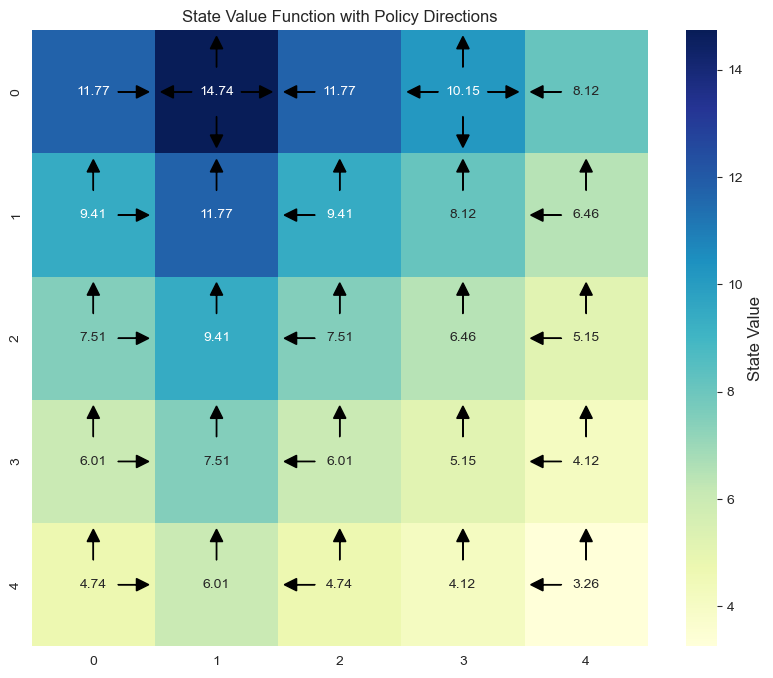

[Info] - Policy Iteration
Iteration:  2
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  0.07294082414417957
[Info] - Policy Improvement
Policy Stable:  True


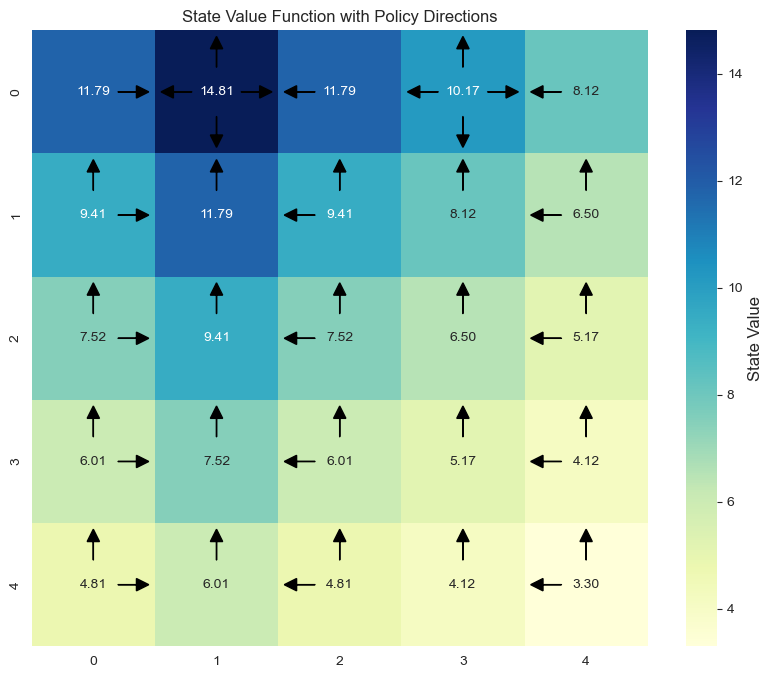

(<__main__.StateValueFunction at 0x2206a342a90>,
 <__main__.Actor at 0x2206a35e2e0>)

In [9]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = StateValueFunction(state_space_shape=grid_shape)
algorithm = GPIstate(actor, value_function, env, grid_shape)

algorithm.train_policy_iteration()

## Value Iteration

[Info] - Starting Value Iteration Algorithm
[Info] - Policy Iteration
Iteration:  0
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  10.0
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  1
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  8.5
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  2
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  6.4
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  3
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  5.120000000000001
[Info] - Policy Improvement
Policy Stable:  False


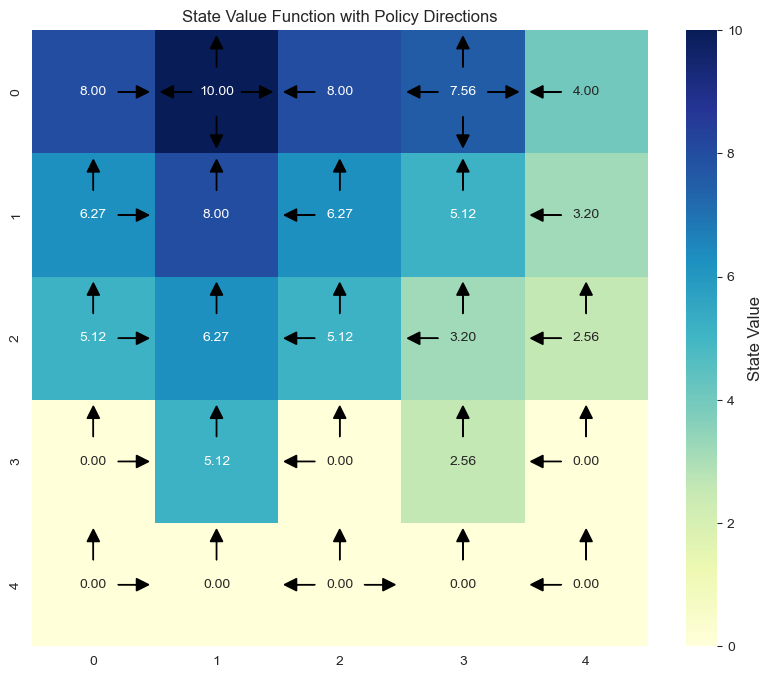

[Info] - Policy Iteration
Iteration:  4
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  4.096000000000001
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  5
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  3.2768000000000015
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  6
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  2.6214400000000015
[Info] - Policy Improvement
Policy Stable:  False


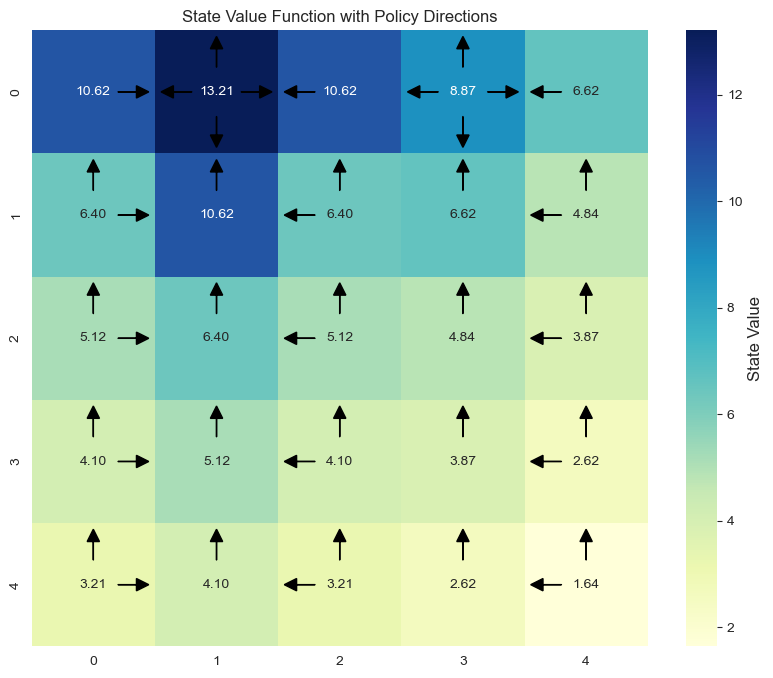

[Info] - Policy Iteration
Iteration:  7
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  2.0971520000000012
[Info] - Policy Improvement
Policy Stable:  True


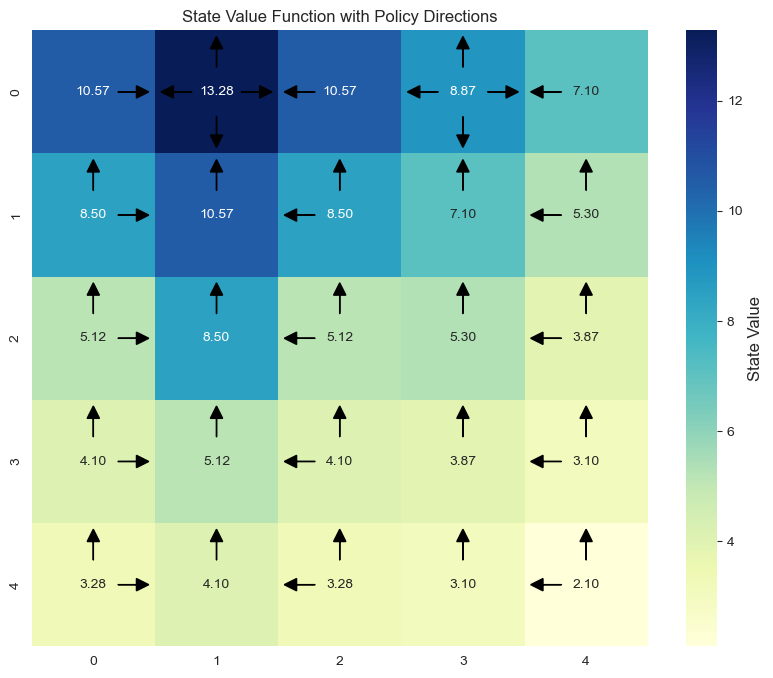

(<__main__.StateValueFunction at 0x2206a35e100>,
 <__main__.Actor at 0x2206efb1790>)

In [10]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = StateValueFunction(state_space_shape=grid_shape)
algorithm = GPIstate(actor, value_function, env, grid_shape)

algorithm.train_value_iteration()

# GPI with Action Values

In [11]:
from typing import Optional, Union


class GPIaction:
    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        grid_shape: np.ndarray,
        gamma=0.8,
        theta: Optional[int] = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.grid_shape = grid_shape

        self.gamma = gamma
        self.theta = theta

    def policy_evaluation(self, max_iterations=None):
        delta = float("inf")

        if max_iterations is None:
            max_iterations = float("inf")

        iteration = 0
        while not delta < self.theta and not max_iterations <= iteration:
            # Sweep over all states
            delta = 0.0
            old_value_function = self.value_function.get_copy()

            for state in self.env.all_states():
                transitions = self.env.lookahead(state)

                for action, (next_state, reward) in transitions.items():

                    state_value_tmp = 0.0
                    for action_tmp, action_prob_tmp in self.actor.get_actions(
                        next_state
                    ).items():
                        state_value_tmp += (
                            action_prob_tmp
                            * old_value_function.get_value(next_state, action_tmp)
                        )

                    action_value = reward + self.gamma * state_value_tmp

                    self.value_function.set_value(state, action, action_value)

                    delta = max(
                        delta,
                        abs(old_value_function.get_value(state, action) - action_value),
                    )

            print("Iteration: ", iteration, " Final Delta: ", delta)

            iteration += 1

        return self.value_function

    def policy_improvement(self):
        actions_comparison = []

        for state in self.env.all_states():
            # calculate action values
            actions_tmp = self.actor.get_actions(state)
            actions_value = self.value_function.get_action_values_from_state(state)

            # update action probabilities greedy based on action values
            max_actions_val = np.max(actions_value)
            max_actions_idc = [
                idx
                for idx, action_value in enumerate(actions_value)
                if action_value == max_actions_val
            ]

            actions_prob = []
            tmp_prob = 1 / len(max_actions_idc)

            for action, action_prob_tmp in actions_tmp.items():
                if action in max_actions_idc:
                    action_prob = tmp_prob
                else:
                    action_prob = 0.0

                actions_prob.append(action_prob)
                actions_comparison.append(np.isclose(action_prob_tmp, action_prob))

            self.actor.set_probs(state, actions_prob)

        policy_stable = all(actions_comparison)
        print("Policy Stable: ", policy_stable)

        return policy_stable

    def train_policy_iteration(
        self,
        num_max_iterations=100,
    ):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation()

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_action(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_value_iteration(self, num_max_iterations=100):
        iteration = 0
        policy_stable = False

        print("[Info] - Starting Value Iteration Algorithm")

        while iteration < num_max_iterations and not policy_stable:
            print("[Info] - Policy Iteration")
            print("Iteration: ", iteration)

            print("[Info] - Policy Evaluation")
            self.policy_evaluation(max_iterations=1)

            print("[Info] - Policy Improvement")
            policy_stable = self.policy_improvement()

            plot_gridworld_action(self.value_function, self.grid_shape, self.actor)

            iteration += 1

        return self.value_function, self.actor

## Policy Iteration

[Info] - Starting Policy Iteration Algorithm
[Info] - Policy Iteration
Iteration:  0
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  10.0
Iteration:  1  Final Delta:  8.0
Iteration:  2  Final Delta:  2.3600000000000003
Iteration:  3  Final Delta:  0.9360000000000002
Iteration:  4  Final Delta:  0.32319999999999993
Iteration:  5  Final Delta:  0.2128000000000001
Iteration:  6  Final Delta:  0.09484800000000002
[Info] - Policy Improvement
Policy Stable:  False


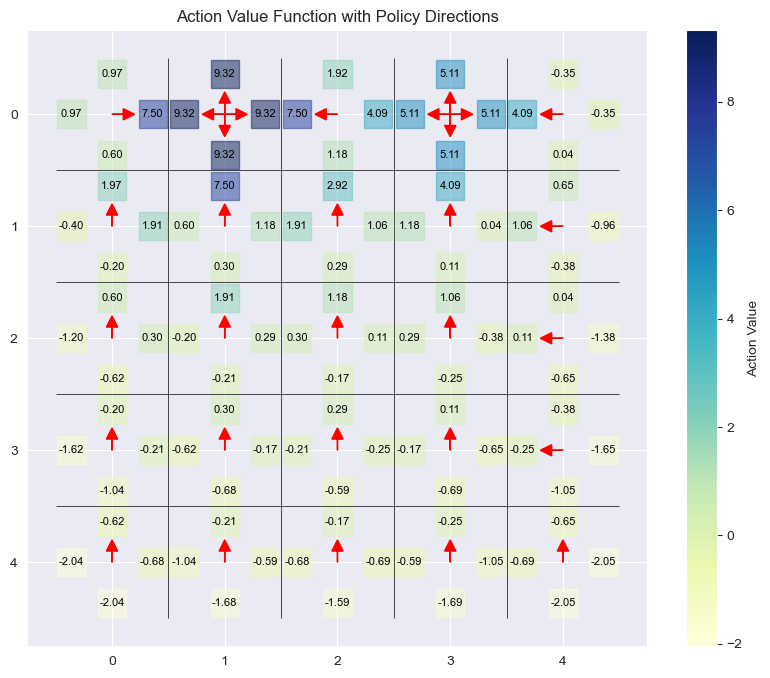

[Info] - Policy Iteration
Iteration:  1
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  4.0889088000000005
Iteration:  1  Final Delta:  3.2711270400000005
Iteration:  2  Final Delta:  2.6169016320000003
Iteration:  3  Final Delta:  2.0935213056000013
Iteration:  4  Final Delta:  1.674817044480001
Iteration:  5  Final Delta:  1.3398536355840012
Iteration:  6  Final Delta:  1.0718829084672006
Iteration:  7  Final Delta:  0.8575063267737608
Iteration:  8  Final Delta:  0.6860050614190087
Iteration:  9  Final Delta:  0.5488040491352071
Iteration:  10  Final Delta:  0.439043239308166
Iteration:  11  Final Delta:  0.35123459144653246
Iteration:  12  Final Delta:  0.2809876731572256
Iteration:  13  Final Delta:  0.22479013852577978
Iteration:  14  Final Delta:  0.179832110820624
Iteration:  15  Final Delta:  0.14386568865649885
Iteration:  16  Final Delta:  0.11509255092519943
Iteration:  17  Final Delta:  0.0920740407401599
[Info] - Policy Improvement
Policy Stable:  False


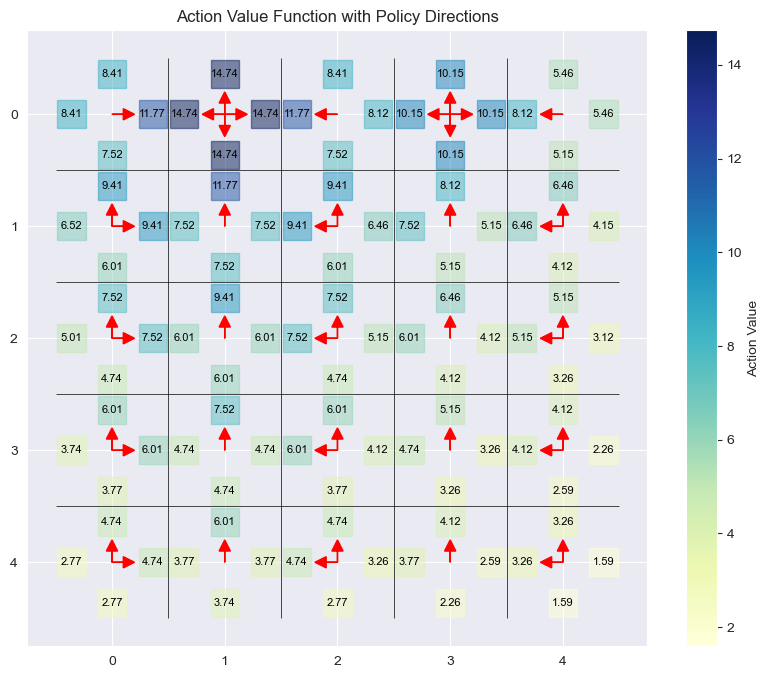

[Info] - Policy Iteration
Iteration:  2
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  0.07365923259212792
[Info] - Policy Improvement
Policy Stable:  True


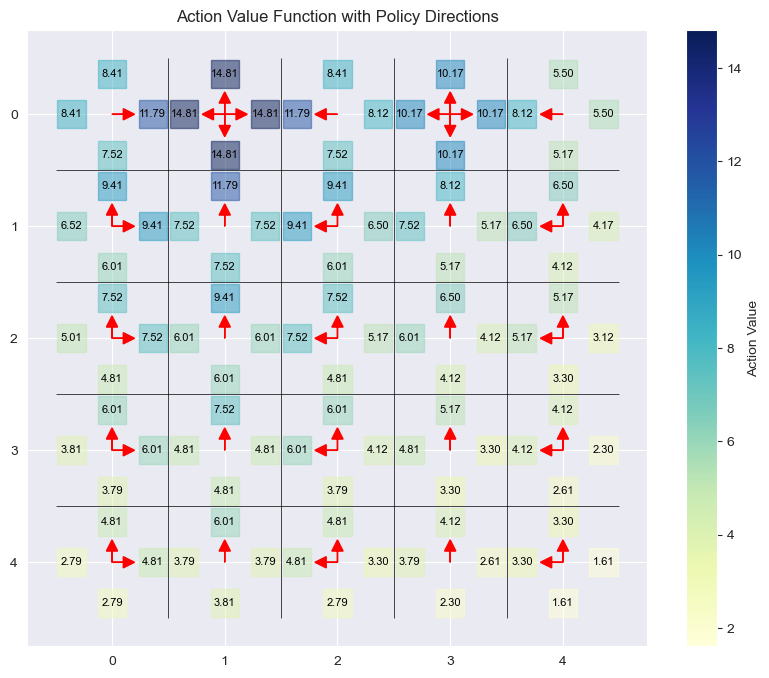

(<__main__.ActionValueFunction at 0x2206ef15670>,
 <__main__.Actor at 0x2206a342550>)

In [12]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1
num_actions = env.action_space.n

actor = Actor(num_states=grid_shape, num_actions=num_actions)
value_function = ActionValueFunction(
    state_space_shape=grid_shape, n_actions=num_actions
)
algorithm = GPIaction(actor, value_function, env, grid_shape)

algorithm.train_policy_iteration()

## Value Iteration

[Info] - Starting Value Iteration Algorithm
[Info] - Policy Iteration
Iteration:  0
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  10.0
[Info] - Policy Improvement
Policy Stable:  False


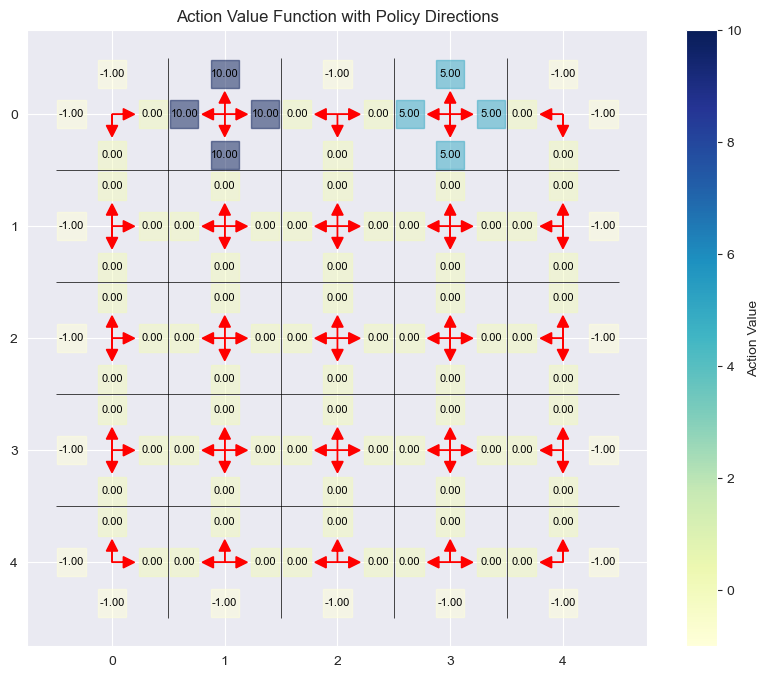

[Info] - Policy Iteration
Iteration:  1
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  8.0
[Info] - Policy Improvement
Policy Stable:  False


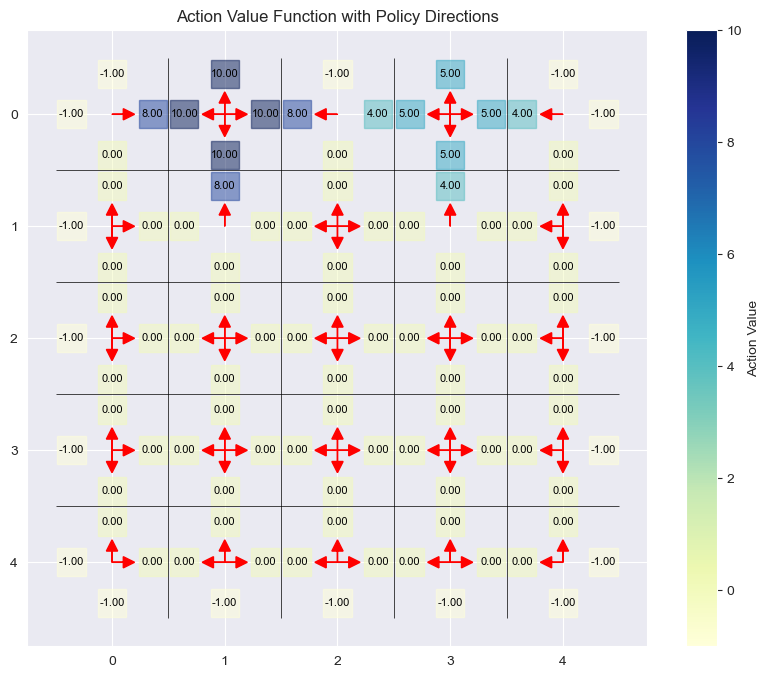

[Info] - Policy Iteration
Iteration:  2
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  6.4
[Info] - Policy Improvement
Policy Stable:  False


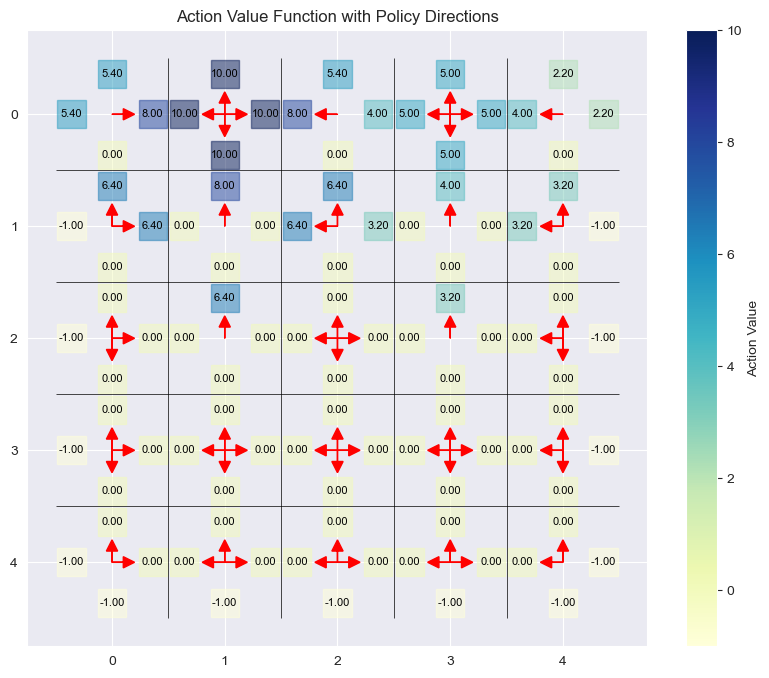

[Info] - Policy Iteration
Iteration:  3
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  5.120000000000001
[Info] - Policy Improvement
Policy Stable:  False


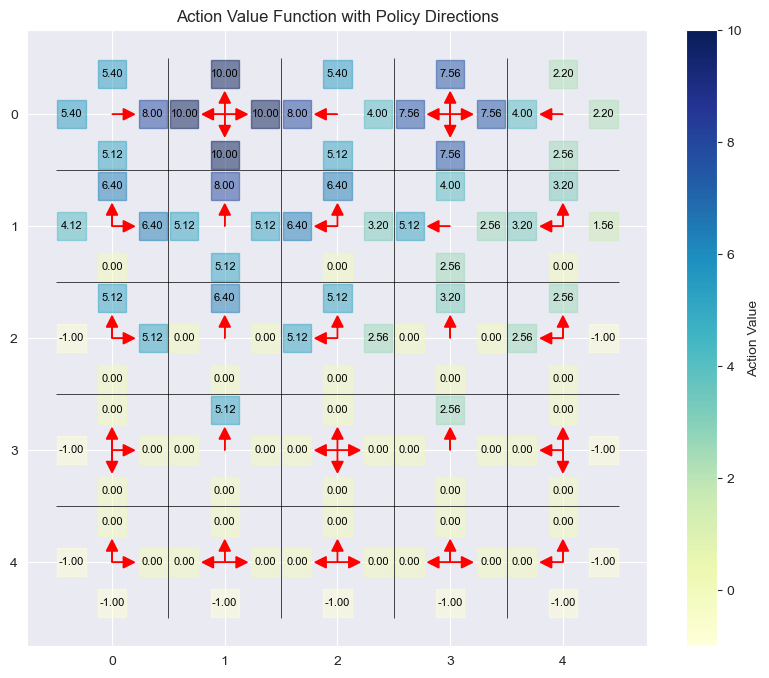

[Info] - Policy Iteration
Iteration:  4
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  4.096000000000001
[Info] - Policy Improvement
Policy Stable:  False


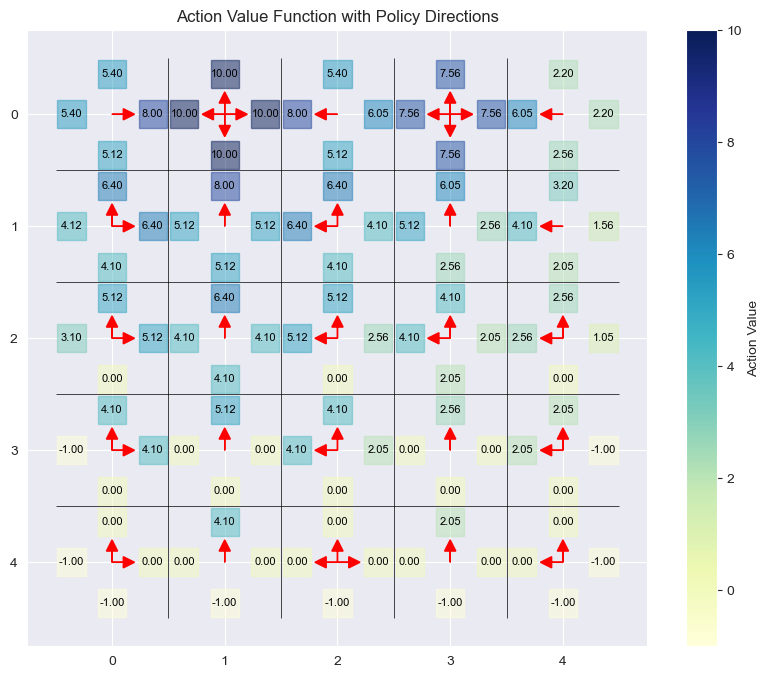

[Info] - Policy Iteration
Iteration:  5
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  3.2768000000000015
[Info] - Policy Improvement
Policy Stable:  False


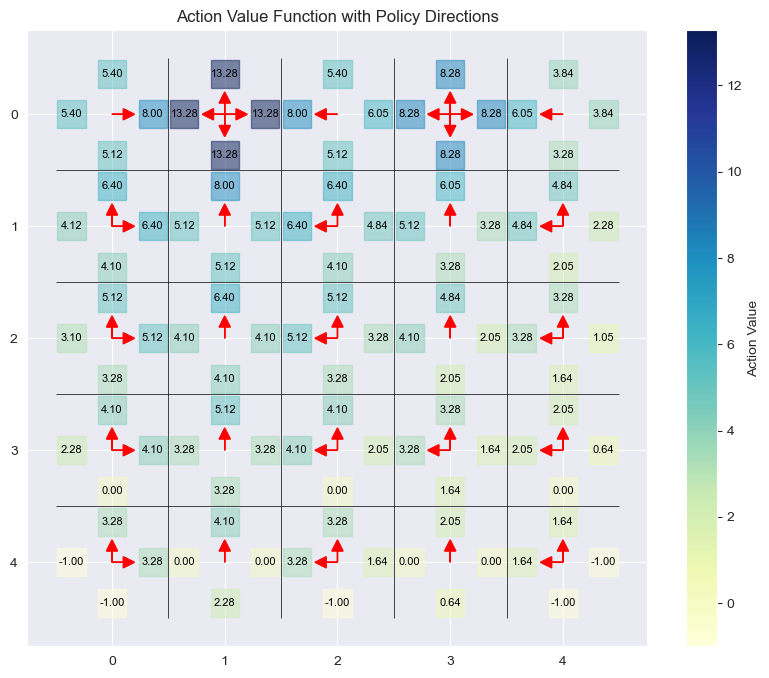

[Info] - Policy Iteration
Iteration:  6
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  2.6214400000000015
[Info] - Policy Improvement
Policy Stable:  False


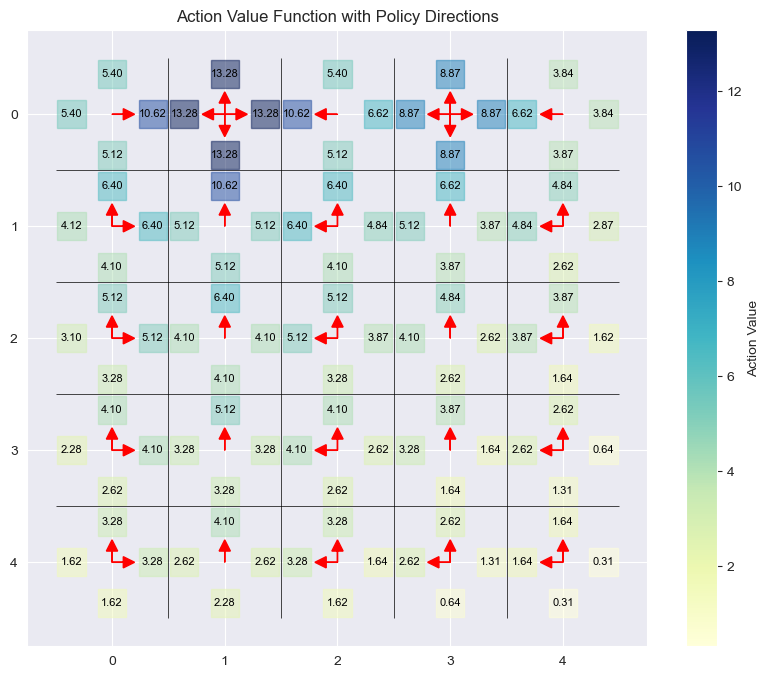

[Info] - Policy Iteration
Iteration:  7
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  2.0971520000000012
[Info] - Policy Improvement
Policy Stable:  False


[Info] - Policy Iteration
Iteration:  8
[Info] - Policy Evaluation
Iteration:  0  Final Delta:  1.6777216000000008
[Info] - Policy Improvement
Policy Stable:  True


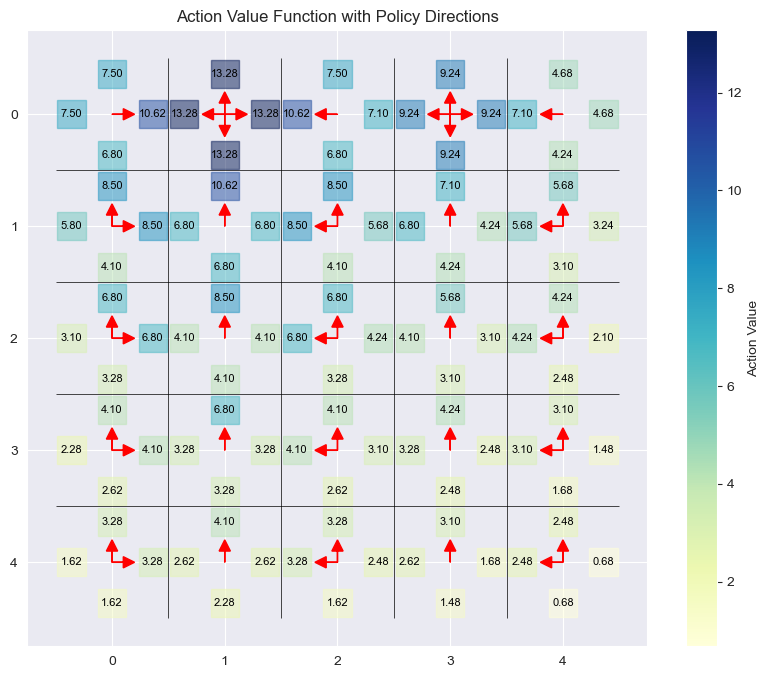

(<__main__.ActionValueFunction at 0x2206fc9f970>,
 <__main__.Actor at 0x2206efb13a0>)

In [13]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0])))
env.reset()

grid_shape = env.observation_space.high + 1
num_actions = env.action_space.n

actor = Actor(num_states=grid_shape, num_actions=num_actions)
value_function = ActionValueFunction(
    state_space_shape=grid_shape, n_actions=num_actions
)
algorithm = GPIaction(actor, value_function, env, grid_shape)

algorithm.train_value_iteration()

# Monte Carlo


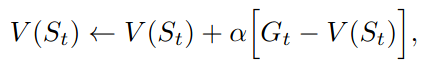

In [14]:
class MC():
    """Collection of Monte Carlo Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        actor_target: Optional[Actor] = None,
        gamma: float = 0.8,
        epsilon: float = 0.1,
    ):
        self.actor = actor
        self.actor_target = actor_target
        self.env = env
        self.value_function = value_fct

        self.gamma = gamma      # discount
        self.epsilon = epsilon  # greedy policy

        # data containers
        self.episode_data = []
        
        state_space_shape = (env.unwrapped.size, env.unwrapped.size)
        n_actions = env.action_space.n

        self.first_visit = np.zeros((*state_space_shape, n_actions), dtype=bool)
        self.returns_count = np.zeros((*state_space_shape, n_actions))
        self.returns_sum = np.zeros((*state_space_shape, n_actions))
        self.importance_weights = np.zeros((*state_space_shape, n_actions))



    def sample_episode(self):
        """
        Generates an episode by executing the current policy in the given environment.
        """

        state, _ = env.reset()
        terminated = truncated = False
        episode_return = 0.

        while not terminated and not truncated:
            # take a step
            action = actor.sample_action(state)
            state_, reward, terminated, truncated, _ = env.step(action)
            self.episode_data.append((state, action, reward))

            # update state
            state = state_
            episode_return += reward

        print('Episode Return: ', episode_return)


    def on_policy_control_algorithm(self):
        # first visit
        return_G = 0.
        self.first_visit[:] = False
        value_delta = 0.0

        for state, action, reward in reversed(self.episode_data):
            state_action_idx = tuple(state) + (action, )
            
            return_G = reward + self.gamma * return_G
            
            if not self.first_visit[state_action_idx]:
                self.first_visit[state_action_idx] = True
                
                # update return data container
                self.returns_sum[state_action_idx] += return_G
                self.returns_count[state_action_idx] += 1

                # calculate and set state value
                avg_return = self.returns_sum[state_action_idx] / self.returns_count[state_action_idx]
                old_value = self.value_function.get_value(state, action)
                self.value_function.set_value(state, action, avg_return)

                # improve policy
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(tuple(state), action_values, self.epsilon)

            value_delta = max(value_delta, abs(old_value - avg_return))

        print('max episode delta: ', value_delta)        



    def off_policy_ordinary_importance_sampling_control(self):
        pass


    def off_policy_weighted_importance_sampling_control(self):
        pass


    def train_on_policy(self, num_episodes: int):
        iteration = 0

        print("[Info] - Starting Policy Iteration Algorithm")

        while iteration < num_episodes:
            print(f"------ Iteration {iteration} ------")
            
            print("[Info] - Sampling Episode")
            self.sample_episode()

            print("[Info] - On-Policy Monte Carlo Control")
            self.on_policy_control_algorithm()


            if iteration % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)

            iteration += 1

        return self.value_function, self.actor

    def train_off_policy(self, num_episodes: int, weighted_sampling=False):
        iteration = 0

        print("[Info] - Starting Off-Policy Monte Carlo Control Algorithm")

        while iteration < num_episodes:
            print(f"------ Iteration {iteration} ------")
            
            print("[Info] - Sampling Episode with Behavior Policy")
            self.sample_episode()

            print("[Info] - Off-Policy Monte Carlo Control")
            if not weighted_sampling:
                self.off_policy_ordinary_importance_sampling_control()
            else:
                self.off_policy_weighted_importance_sampling_control()

            if iteration % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)

            iteration += 1

        return self.value_function, self.actor


## First Visit Monte Carlo Control

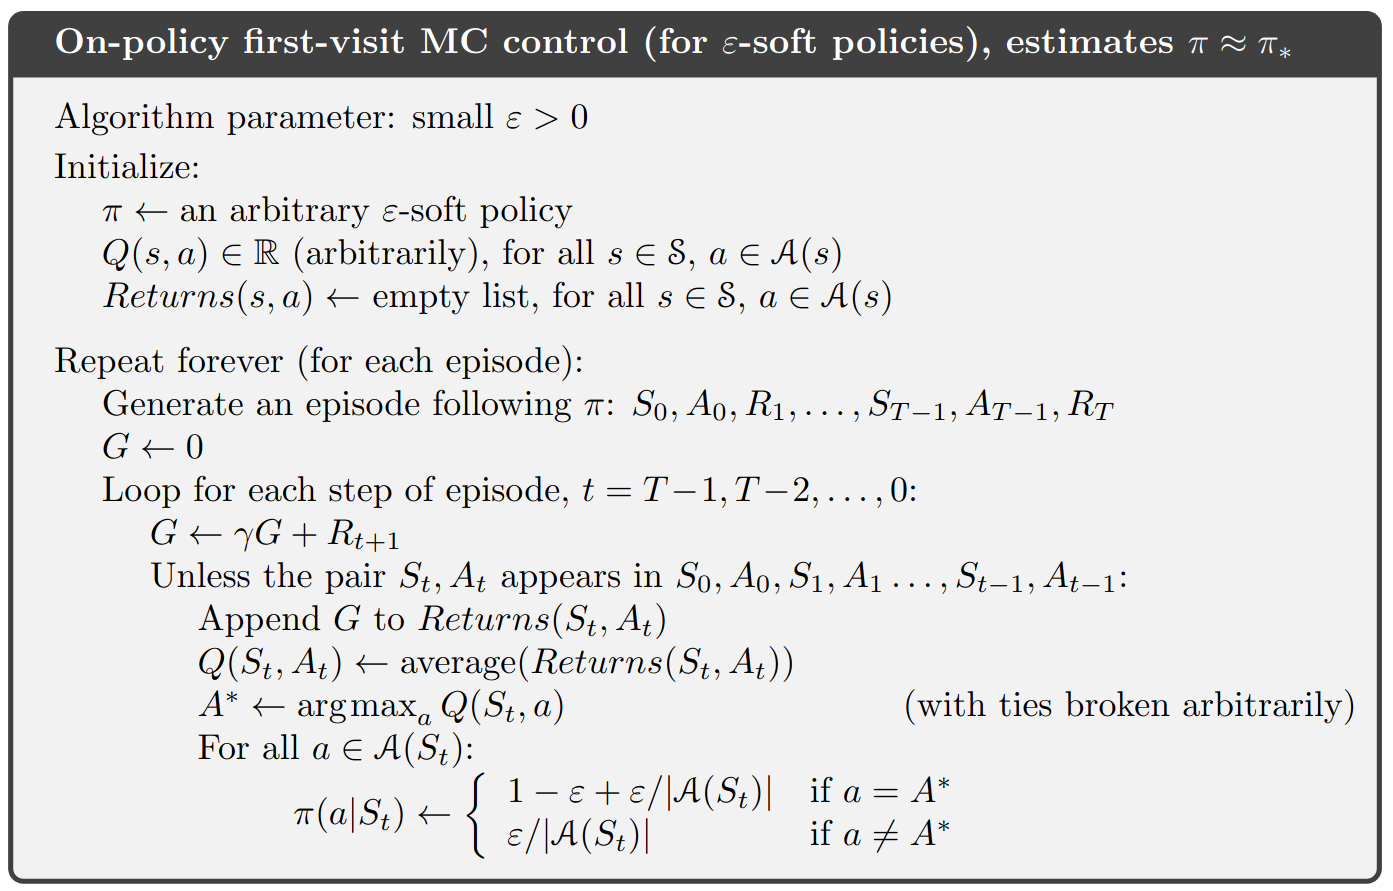

[Info] - Starting Policy Iteration Algorithm
------ Iteration 0 ------
[Info] - Sampling Episode
Episode Return:  14.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  9.8926258176


------ Iteration 1 ------
[Info] - Sampling Episode
Episode Return:  -10.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  3.2953569280000004
------ Iteration 2 ------
[Info] - Sampling Episode
Episode Return:  31.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  10.0
------ Iteration 3 ------
[Info] - Sampling Episode
Episode Return:  37.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  8.01142435547423
------ Iteration 4 ------
[Info] - Sampling Episode
Episode Return:  57.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  10.657152
------ Iteration 5 ------
[Info] - Sampling Episode
Episode Return:  36.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  9.942660797269982
------ Iteration 6 ------
[Info] - Sampling Episode
Episode Return:  37.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  1.7365114891137094
------ Iteration 7 ------
[Info] - Sampling Episode
Episode Return:  29.0
[Info] - On-Policy Monte Carlo Control


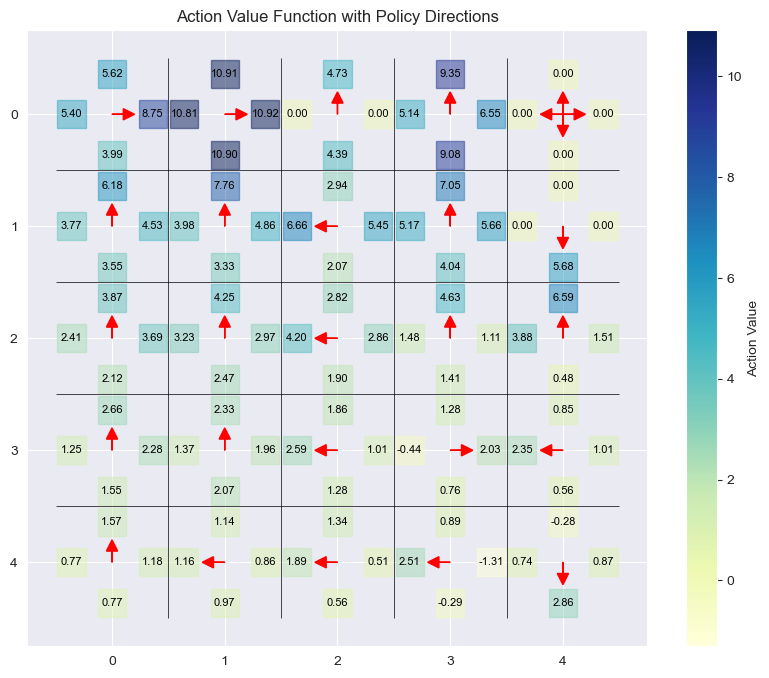

------ Iteration 101 ------
[Info] - Sampling Episode
Episode Return:  38.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  5.873297230790659
------ Iteration 102 ------
[Info] - Sampling Episode
Episode Return:  77.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.06233953231482481
------ Iteration 103 ------
[Info] - Sampling Episode
Episode Return:  69.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.06003066074760888
------ Iteration 104 ------
[Info] - Sampling Episode
Episode Return:  44.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.05784772762951418
------ Iteration 105 ------
[Info] - Sampling Episode
Episode Return:  65.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.05578173735703151
------ Iteration 106 ------
[Info] - Sampling Episode
Episode Return:  66.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.05382448341467905
------ Iteration 107 ------
[Info] - Sampling Episode
Episode Return:  5

------ Iteration 201 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.04237375740720317
------ Iteration 202 ------
[Info] - Sampling Episode
Episode Return:  66.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.03201393239127803
------ Iteration 203 ------
[Info] - Sampling Episode
Episode Return:  54.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.03215800116947687
------ Iteration 204 ------
[Info] - Sampling Episode
Episode Return:  53.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.030533671221887104
------ Iteration 205 ------
[Info] - Sampling Episode
Episode Return:  69.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.02983174774552122
------ Iteration 206 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.029153753478577293
------ Iteration 207 ------
[Info] - Sampling Episode
Episode Return

------ Iteration 301 ------
[Info] - Sampling Episode
Episode Return:  58.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018967491271451475
------ Iteration 302 ------
[Info] - Sampling Episode
Episode Return:  46.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.01881755062898982
------ Iteration 303 ------
[Info] - Sampling Episode
Episode Return:  48.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018669380938997726
------ Iteration 304 ------
[Info] - Sampling Episode
Episode Return:  64.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018522954421828608
------ Iteration 305 ------
[Info] - Sampling Episode
Episode Return:  89.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018378243840408537
------ Iteration 306 ------
[Info] - Sampling Episode
Episode Return:  70.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018235222487564595
------ Iteration 307 ------
[Info] - Sampling Episode
Episode Ret

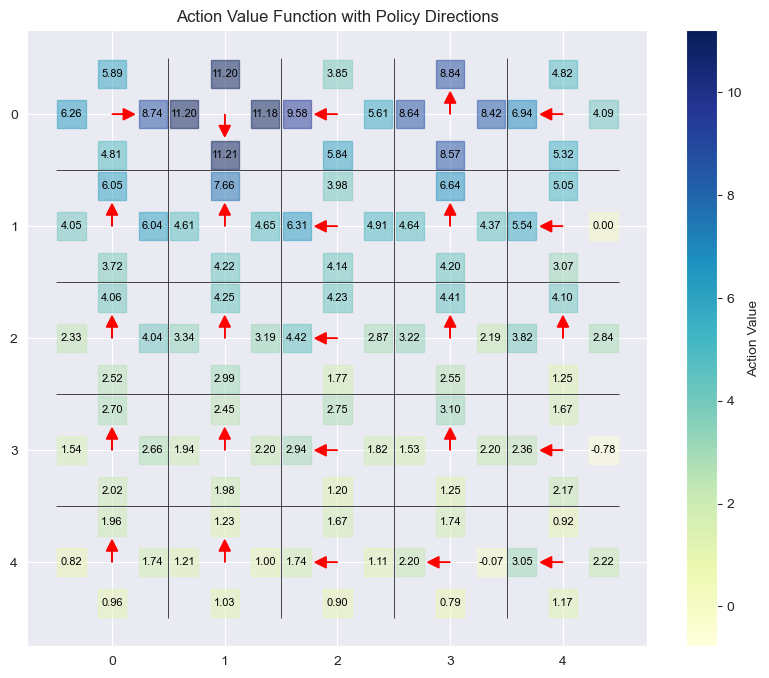

------ Iteration 401 ------
[Info] - Sampling Episode
Episode Return:  56.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.013394627171667395
------ Iteration 402 ------
[Info] - Sampling Episode
Episode Return:  66.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.013327821051110966
------ Iteration 403 ------
[Info] - Sampling Episode
Episode Return:  48.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.012895578466131447
------ Iteration 404 ------
[Info] - Sampling Episode
Episode Return:  65.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.012831580558110945
------ Iteration 405 ------
[Info] - Sampling Episode
Episode Return:  58.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.012768057882080693
------ Iteration 406 ------
[Info] - Sampling Episode
Episode Return:  68.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.018944352646452778
------ Iteration 407 ------
[Info] - Sampling Episode
Episode Re

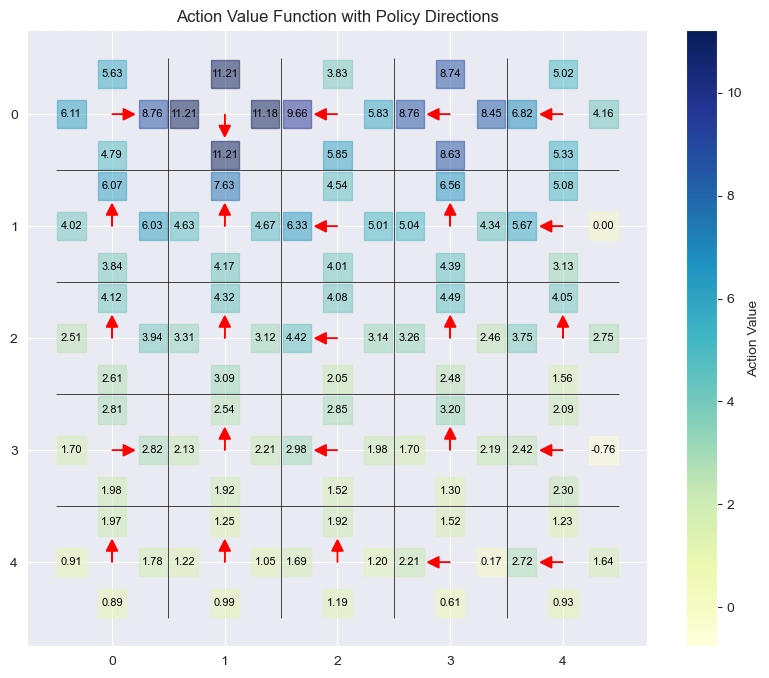

------ Iteration 501 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.008631290609495856
------ Iteration 502 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.007204090014307329
------ Iteration 503 ------
[Info] - Sampling Episode
Episode Return:  68.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.007175273654250525
------ Iteration 504 ------
[Info] - Sampling Episode
Episode Return:  60.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.00805503972162569
------ Iteration 505 ------
[Info] - Sampling Episode
Episode Return:  57.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.015146159999035902
------ Iteration 506 ------
[Info] - Sampling Episode
Episode Return:  61.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.007387460301822912
------ Iteration 507 ------
[Info] - Sampling Episode
Episode Ret

------ Iteration 601 ------
[Info] - Sampling Episode
Episode Return:  60.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.014385385199432221
------ Iteration 602 ------
[Info] - Sampling Episode
Episode Return:  58.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.014268904347613187
------ Iteration 603 ------
[Info] - Sampling Episode
Episode Return:  41.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.09204945041266699
------ Iteration 604 ------
[Info] - Sampling Episode
Episode Return:  55.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.047587618322662006
------ Iteration 605 ------
[Info] - Sampling Episode
Episode Return:  36.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.04579351460105219
------ Iteration 606 ------
[Info] - Sampling Episode
Episode Return:  65.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.04409745853336133
------ Iteration 607 ------
[Info] - Sampling Episode
Episode Retur

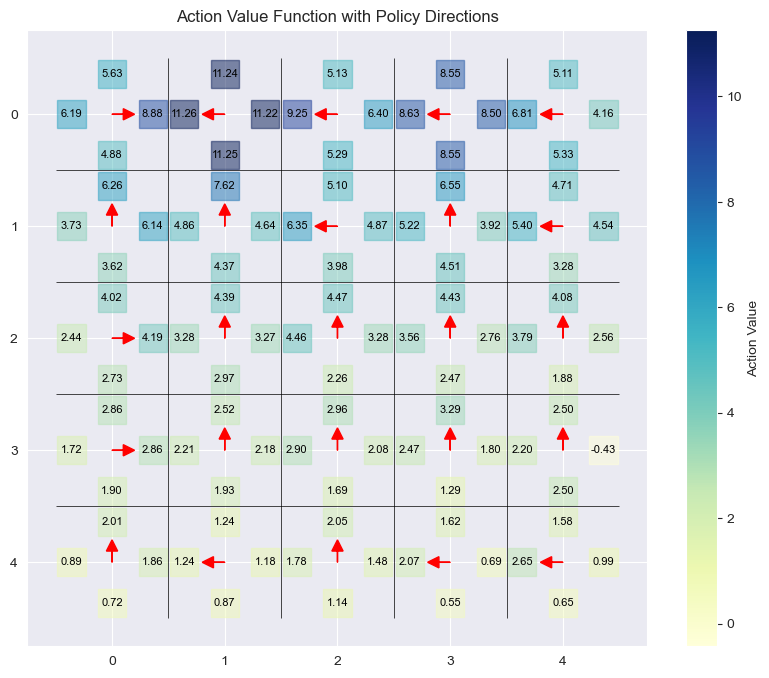

------ Iteration 701 ------
[Info] - Sampling Episode
Episode Return:  47.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0064299335841431215
------ Iteration 702 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.006344201136355032
------ Iteration 703 ------
[Info] - Sampling Episode
Episode Return:  47.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.009023807183278443
------ Iteration 704 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.008441457821148468
------ Iteration 705 ------
[Info] - Sampling Episode
Episode Return:  69.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.006191867115272309
------ Iteration 706 ------
[Info] - Sampling Episode
Episode Return:  56.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.00617239583503526
------ Iteration 707 ------
[Info] - Sampling Episode
Episode Re

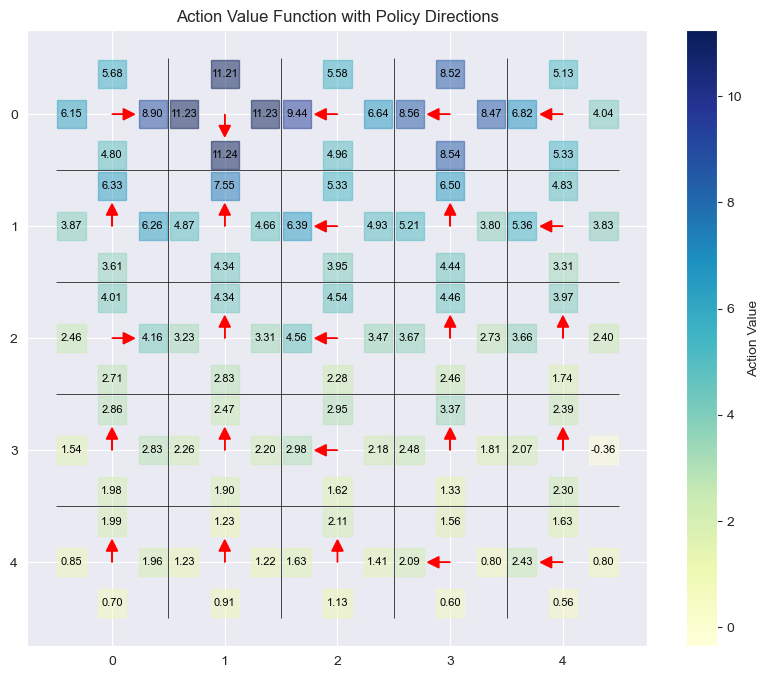

------ Iteration 801 ------
[Info] - Sampling Episode
Episode Return:  79.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0045080185007746465
------ Iteration 802 ------
[Info] - Sampling Episode
Episode Return:  49.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.007965084547943313
------ Iteration 803 ------
[Info] - Sampling Episode
Episode Return:  57.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0051872272394506425
------ Iteration 804 ------
[Info] - Sampling Episode
Episode Return:  50.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0046403458547938925
------ Iteration 805 ------
[Info] - Sampling Episode
Episode Return:  39.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.006888375156330007
------ Iteration 806 ------
[Info] - Sampling Episode
Episode Return:  56.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0068705176141969915
------ Iteration 807 ------
[Info] - Sampling Episode
Episod

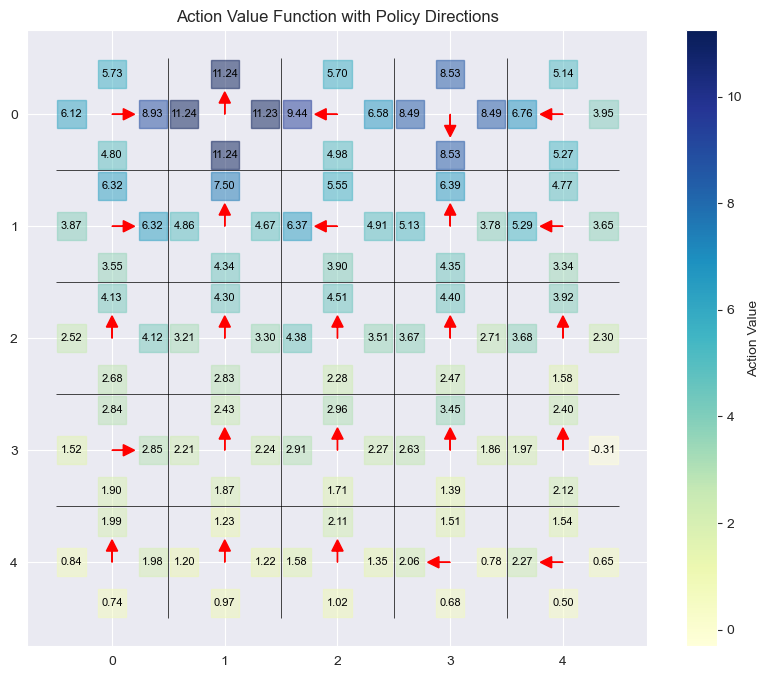

------ Iteration 901 ------
[Info] - Sampling Episode
Episode Return:  50.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0053418938473104305
------ Iteration 902 ------
[Info] - Sampling Episode
Episode Return:  49.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.004818224448022601
------ Iteration 903 ------
[Info] - Sampling Episode
Episode Return:  70.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.004657113278112135
------ Iteration 904 ------
[Info] - Sampling Episode
Episode Return:  59.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.008305985474242661
------ Iteration 905 ------
[Info] - Sampling Episode
Episode Return:  35.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.0048632399287651396
------ Iteration 906 ------
[Info] - Sampling Episode
Episode Return:  36.0
[Info] - On-Policy Monte Carlo Control
max episode delta:  0.007050842136311353
------ Iteration 907 ------
[Info] - Sampling Episode
Episode 

(<__main__.ActionValueFunction at 0x2206f77d640>,
 <__main__.Actor at 0x2206f77de50>)

In [15]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([0, 0]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor, value_function, env, gamma=0.8, epsilon=0.4)

algorithm.train_on_policy(1_000)

## Off-Policy Monte Carlo Control

### Ordinary Importance Sampling

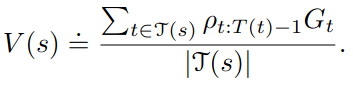

[Info] - Starting Off-Policy Monte Carlo Control Algorithm
------ Iteration 0 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  38.0
[Info] - Off-Policy Monte Carlo Control


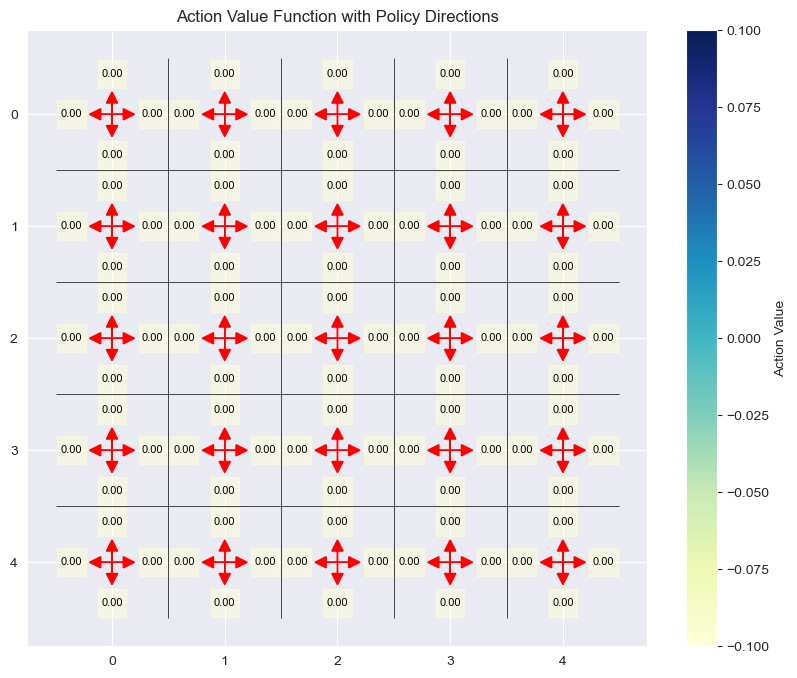

------ Iteration 1 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  54.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 2 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  70.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 3 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  46.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 4 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  64.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 5 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 6 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  43.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 7 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 8 ------
[Info] - Sampling Episode wit

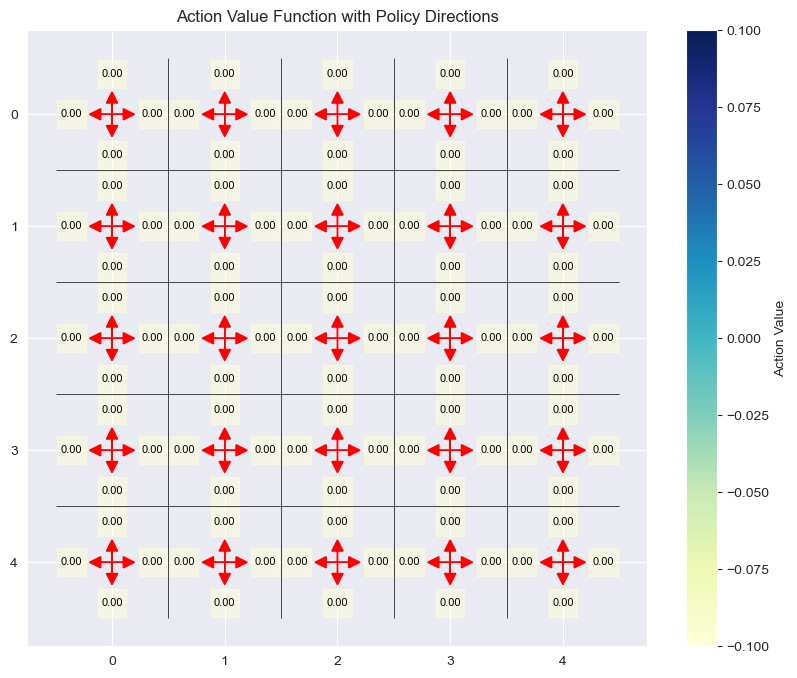

------ Iteration 101 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  47.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 102 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  57.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 103 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  39.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 104 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 105 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  47.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 106 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 107 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  44.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 108 ------
[Info] - Samp

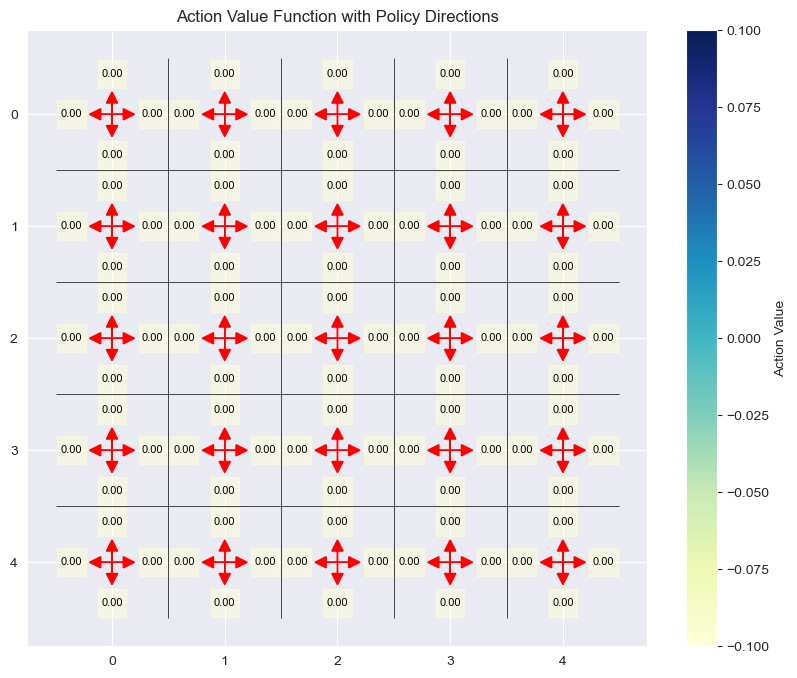

------ Iteration 201 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  70.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 202 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  70.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 203 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 204 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  65.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 205 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  46.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 206 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 207 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  45.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 208 ------
[Info] - Samp

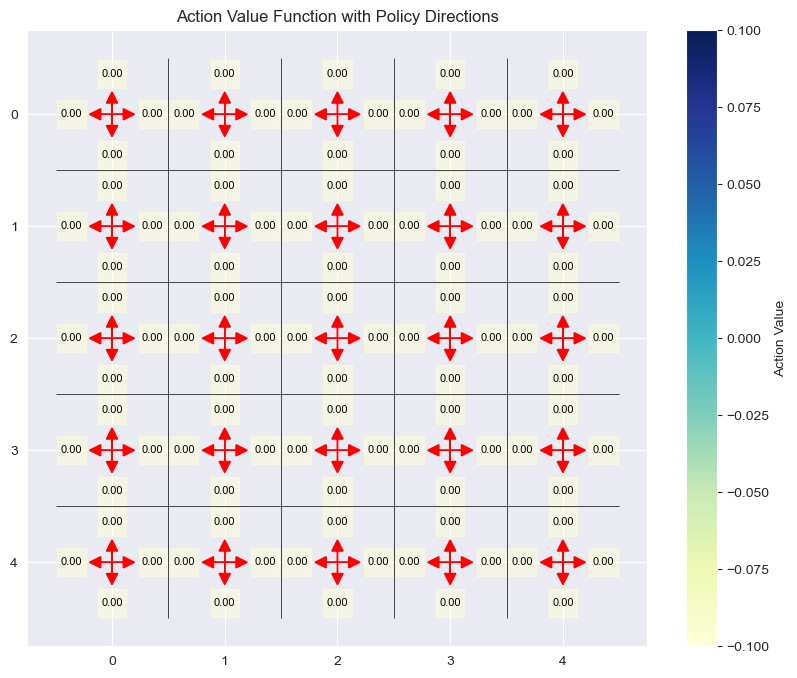

------ Iteration 301 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  63.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 302 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  57.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 303 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  67.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 304 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 305 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 306 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  51.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 307 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  50.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 308 ------
[Info] - Samp

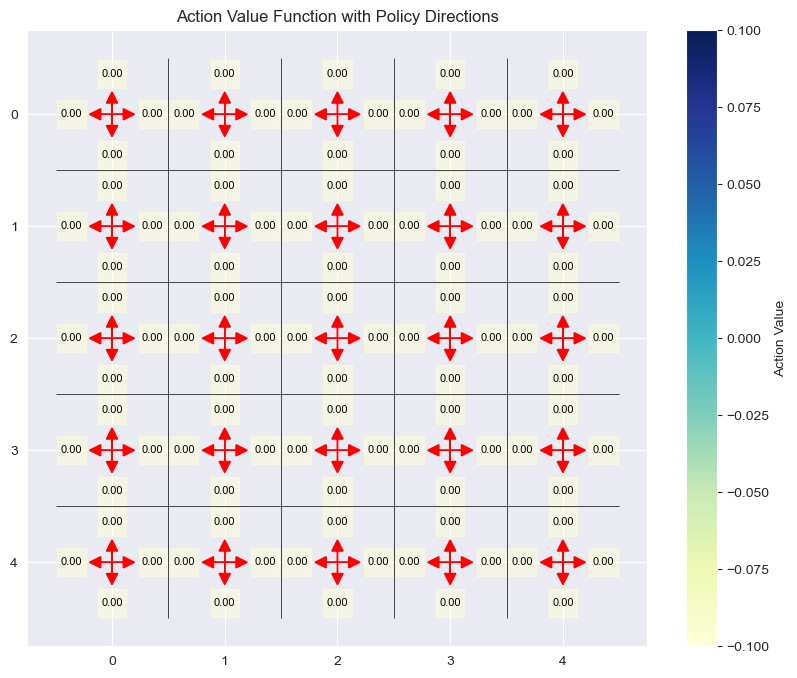

------ Iteration 401 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 402 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  47.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 403 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 404 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  64.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 405 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  67.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 406 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 407 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  64.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 408 ------
[Info] - Samp

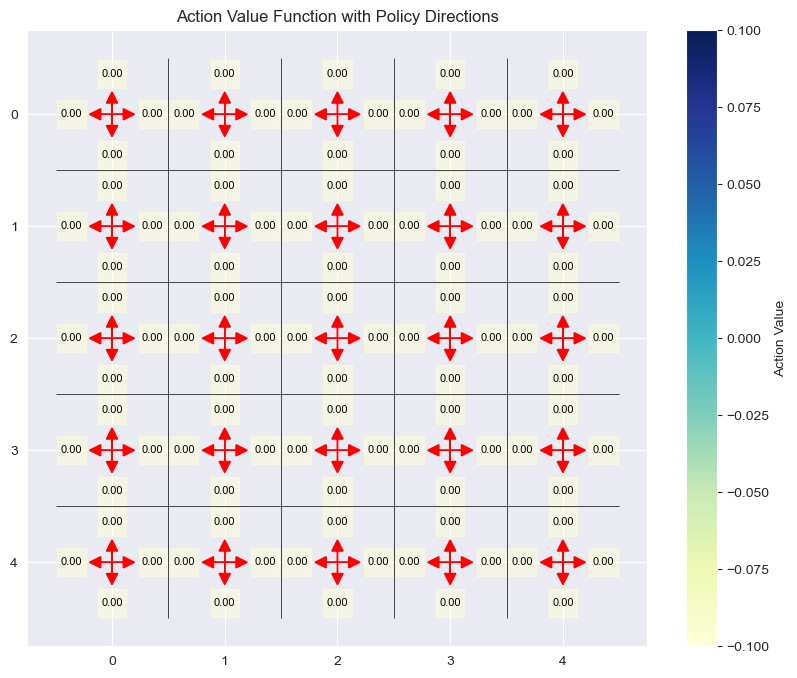

------ Iteration 501 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 502 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  37.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 503 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 504 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 505 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  45.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 506 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 507 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  44.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 508 ------
[Info] - Samp

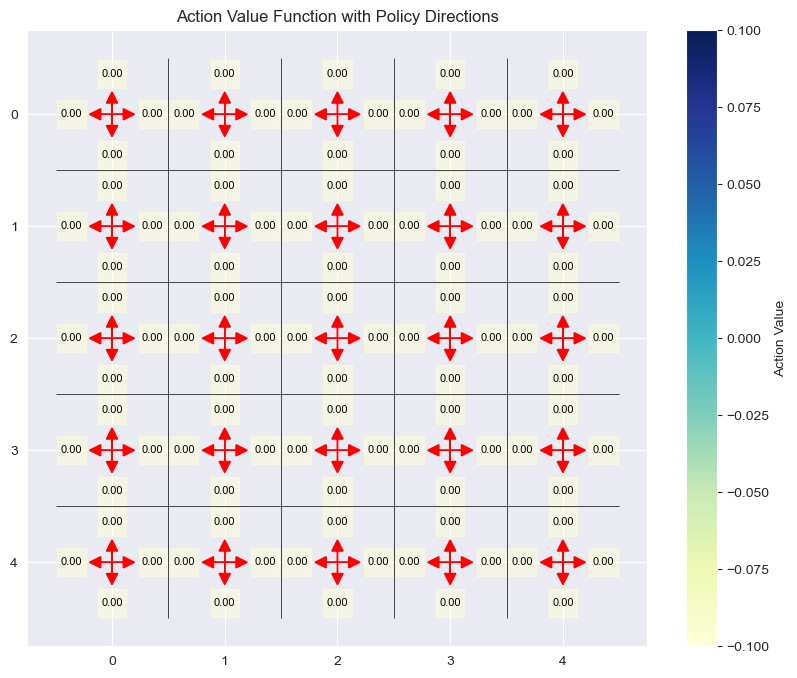

------ Iteration 601 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  69.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 602 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  79.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 603 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  38.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 604 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 605 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 606 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  39.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 607 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 608 ------
[Info] - Samp

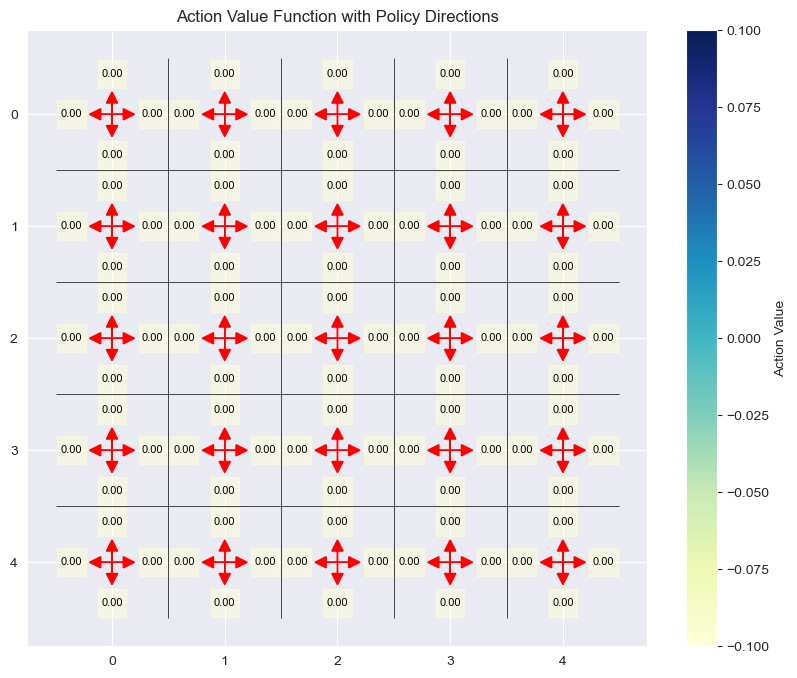

------ Iteration 701 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 702 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  69.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 703 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 704 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  70.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 705 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 706 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  44.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 707 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  65.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 708 ------
[Info] - Samp

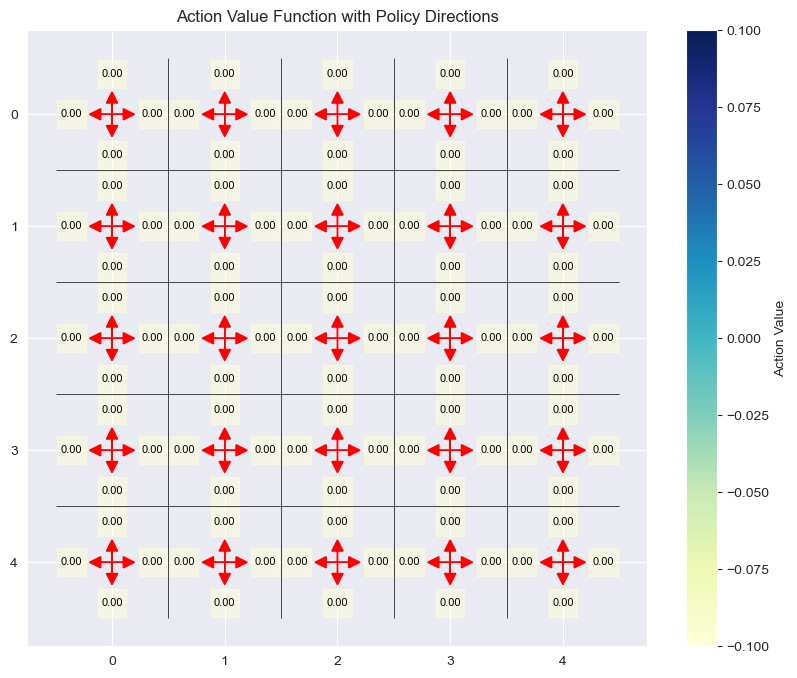

------ Iteration 801 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 802 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 803 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 804 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  54.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 805 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 806 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 807 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 808 ------
[Info] - Samp

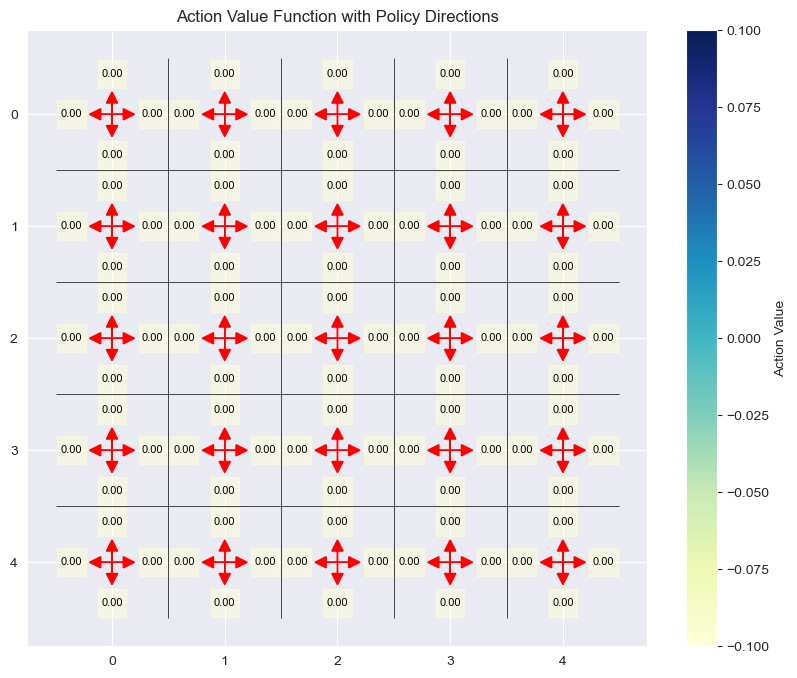

------ Iteration 901 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  79.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 902 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  35.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 903 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  65.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 904 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 905 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  42.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 906 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  53.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 907 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  79.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 908 ------
[Info] - Samp

(<__main__.ActionValueFunction at 0x2206ef81460>,
 <__main__.Actor at 0x2206ef81d30>)

In [16]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor_b = Actor(num_states=grid_shape, num_actions=env.action_space.n)
actor_t = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor_b, value_function, env,actor_target=actor_t, gamma=0.8, epsilon=0.2)

algorithm.train_off_policy(1_000, weighted_sampling=True)

## Weighted Importance Sampling

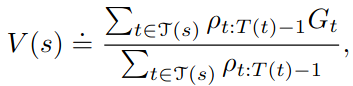

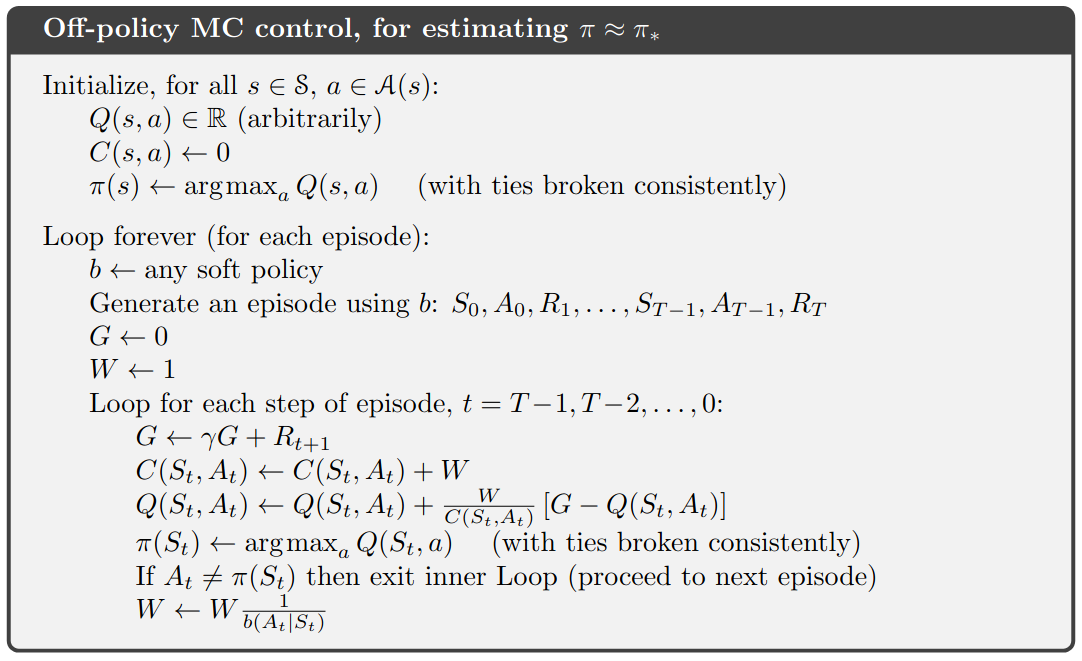

[Info] - Starting Off-Policy Monte Carlo Control Algorithm
------ Iteration 0 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  38.0
[Info] - Off-Policy Monte Carlo Control


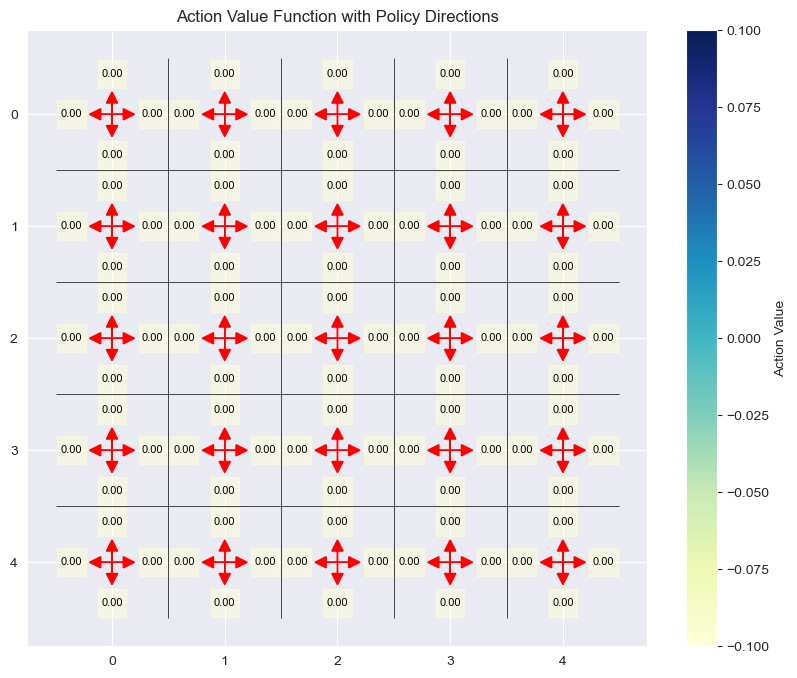

------ Iteration 1 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  54.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 2 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 3 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 4 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  78.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 5 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 6 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  69.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 7 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 8 ------
[Info] - Sampling Episode wit

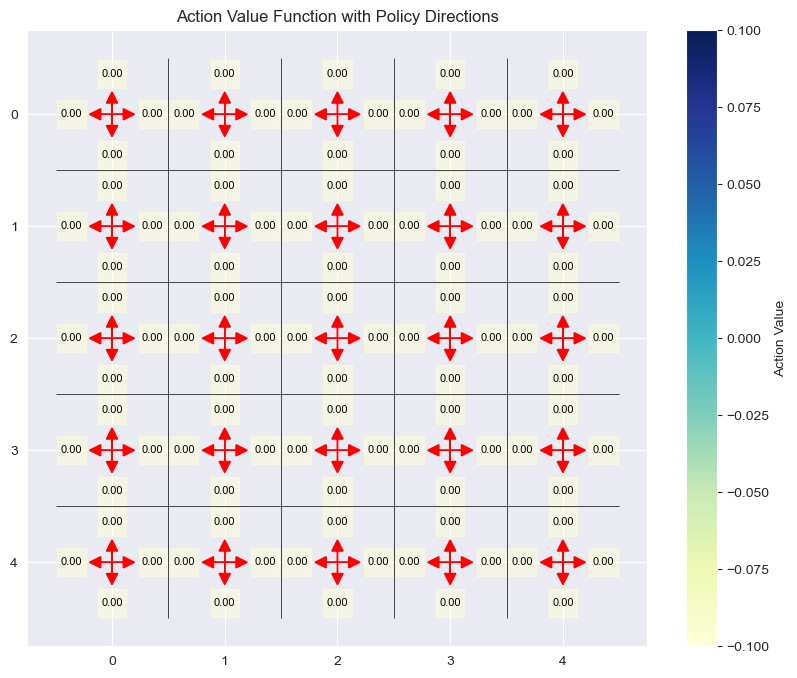

------ Iteration 101 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  50.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 102 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  22.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 103 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 104 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  54.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 105 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  53.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 106 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 107 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  46.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 108 ------
[Info] - Samp

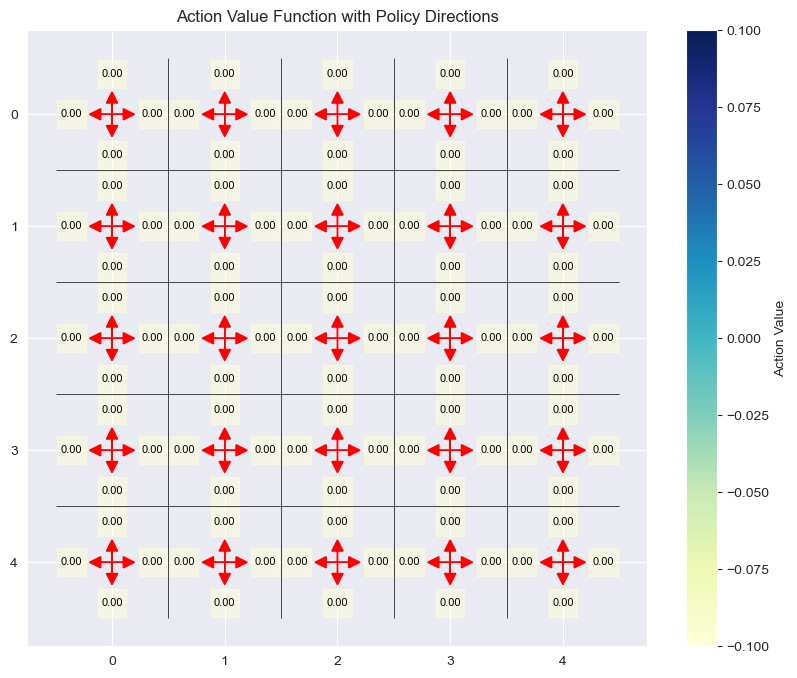

------ Iteration 201 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 202 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 203 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 204 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  47.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 205 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 206 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  51.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 207 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 208 ------
[Info] - Samp

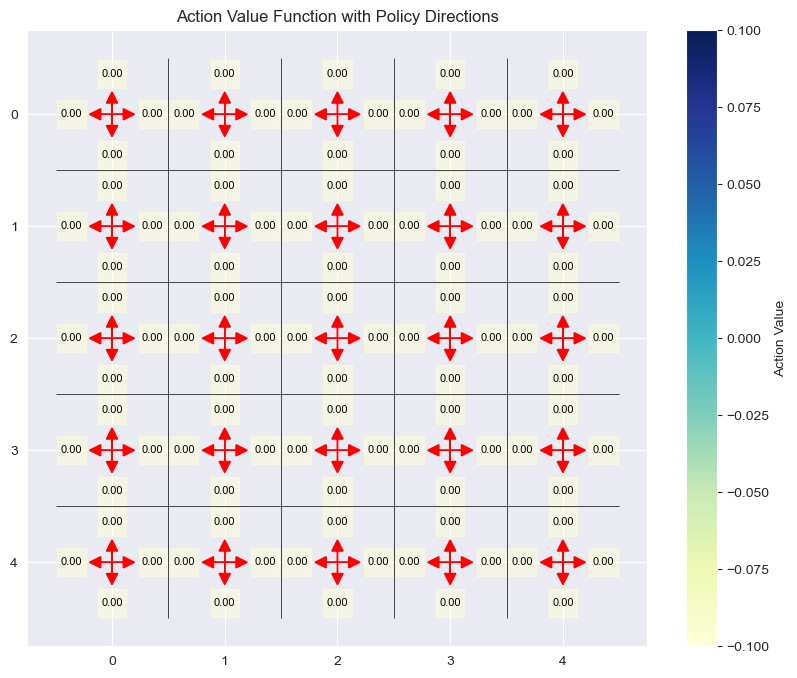

------ Iteration 301 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  65.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 302 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  38.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 303 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  39.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 304 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 305 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  69.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 306 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 307 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  39.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 308 ------
[Info] - Samp

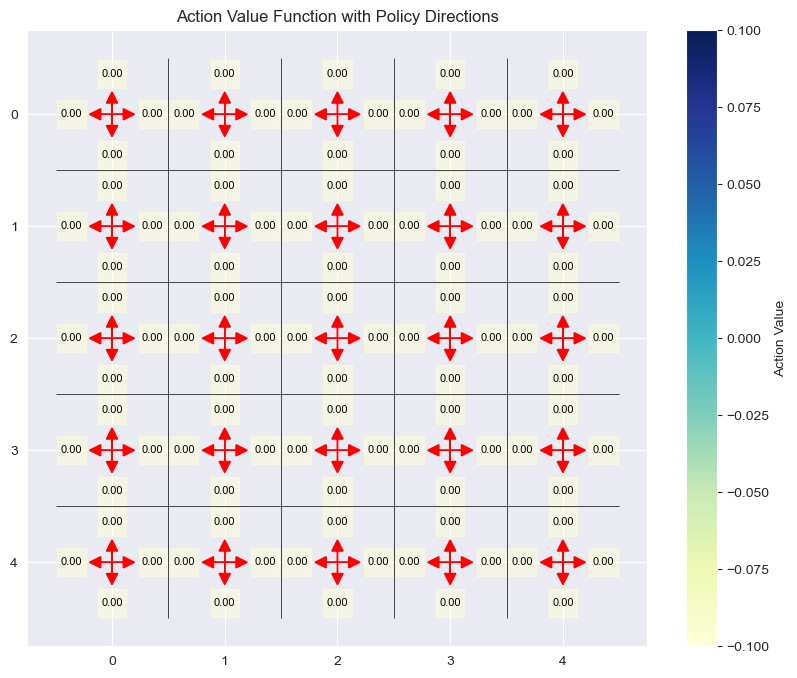

------ Iteration 401 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  66.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 402 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  79.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 403 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 404 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 405 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 406 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 407 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  46.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 408 ------
[Info] - Samp

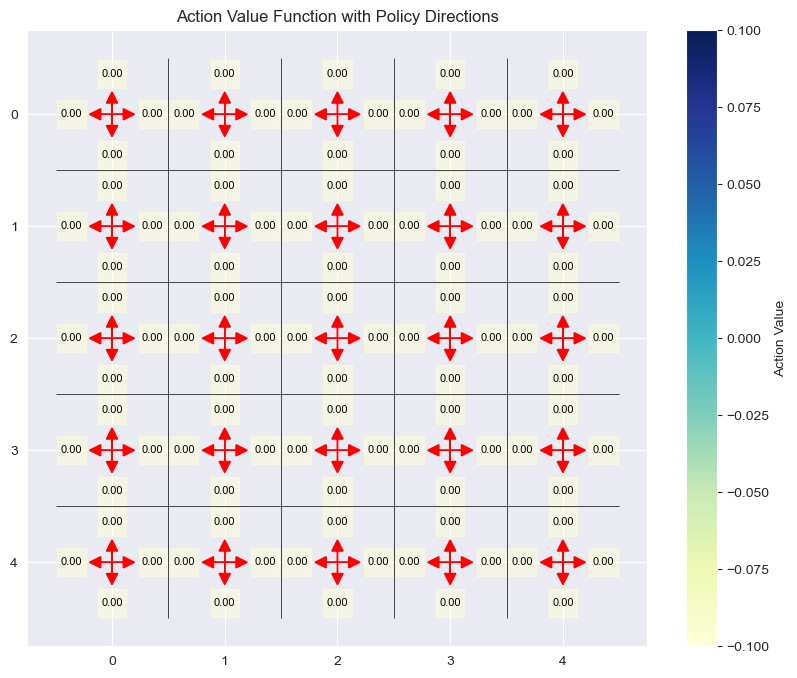

------ Iteration 501 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  35.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 502 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 503 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  68.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 504 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  15.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 505 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  26.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 506 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  51.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 507 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  56.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 508 ------
[Info] - Samp

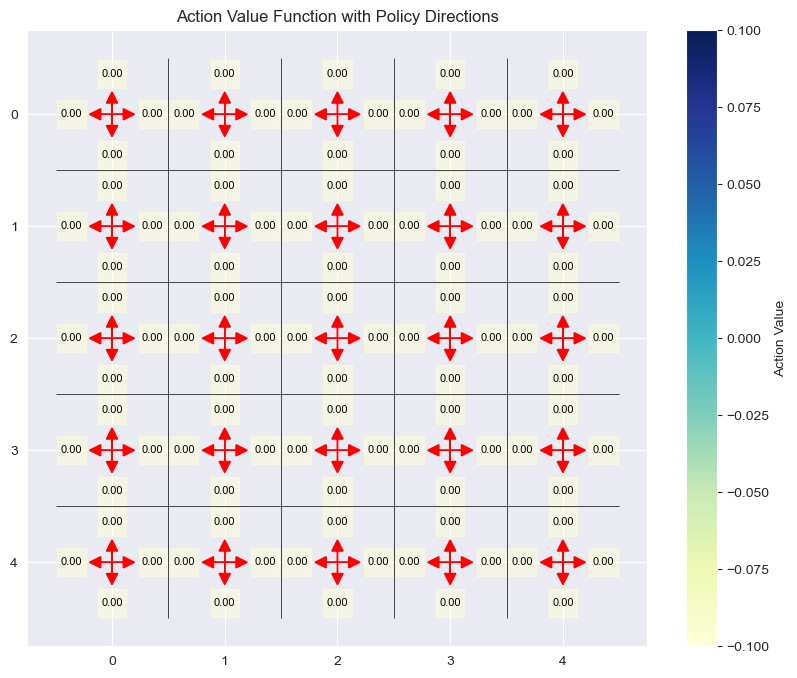

------ Iteration 601 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 602 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 603 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  55.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 604 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  62.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 605 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  37.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 606 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 607 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 608 ------
[Info] - Samp

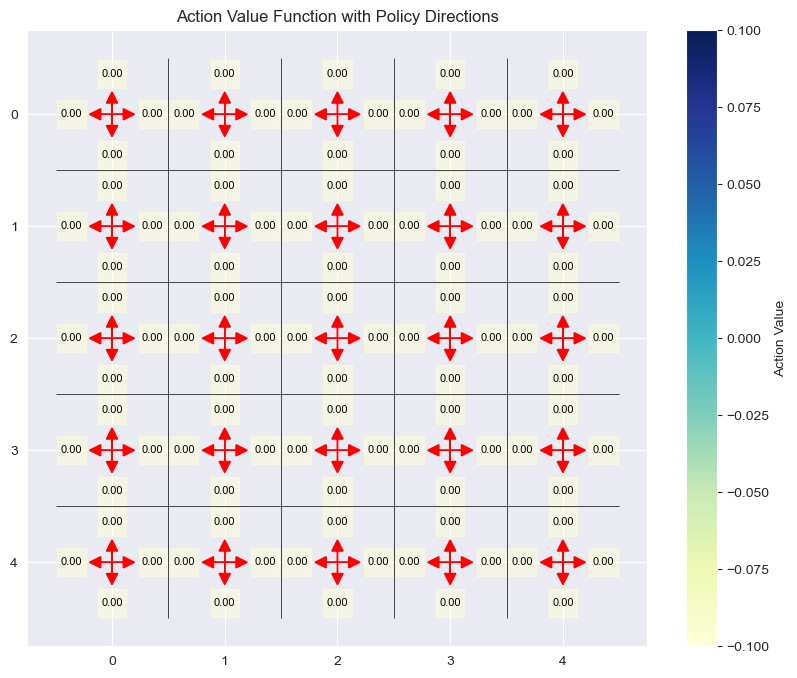

------ Iteration 701 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  54.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 702 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  46.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 703 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 704 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  50.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 705 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  53.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 706 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 707 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  74.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 708 ------
[Info] - Samp

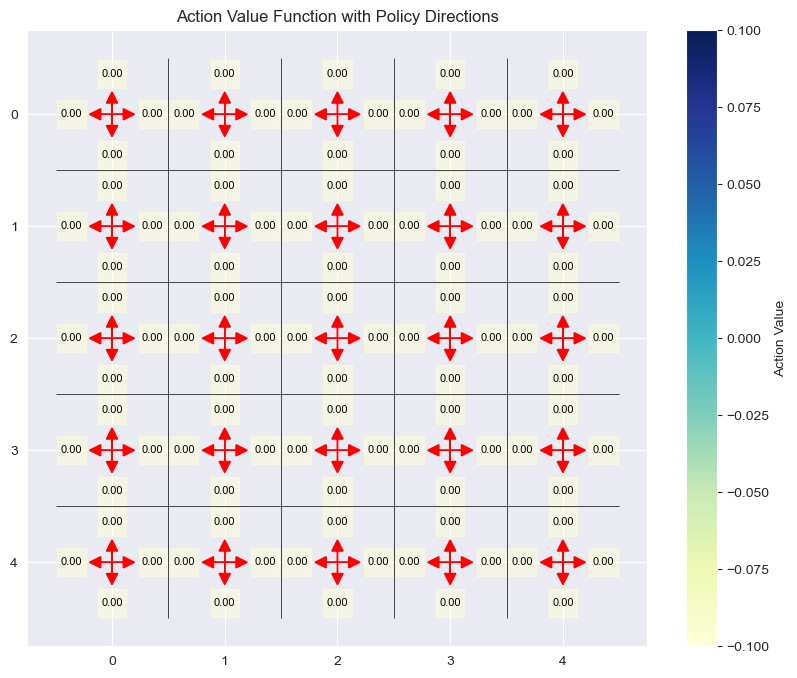

------ Iteration 801 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  44.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 802 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 803 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  58.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 804 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 805 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 806 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  70.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 807 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 808 ------
[Info] - Samp

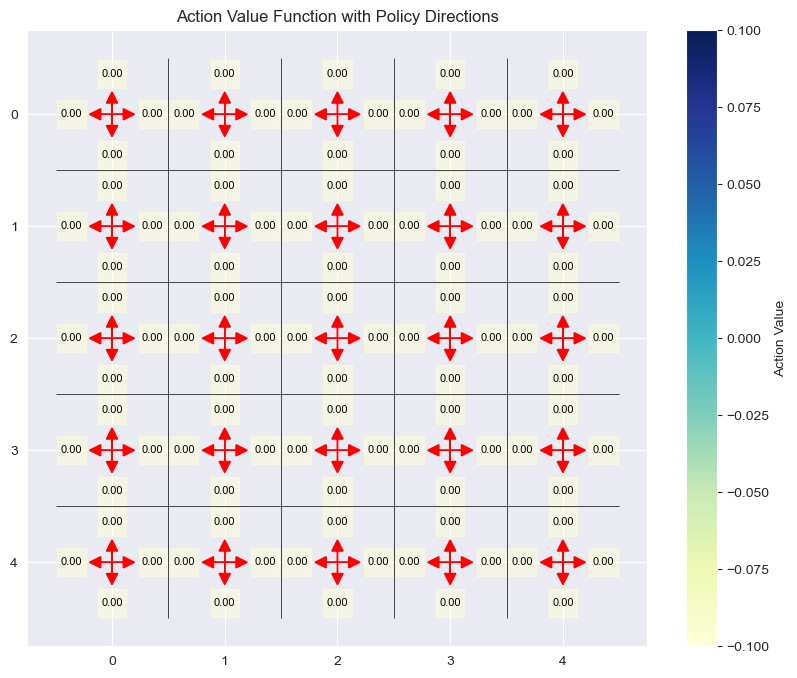

------ Iteration 901 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 902 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 903 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  49.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 904 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  59.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 905 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  48.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 906 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  67.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 907 ------
[Info] - Sampling Episode with Behavior Policy
Episode Return:  60.0
[Info] - Off-Policy Monte Carlo Control
------ Iteration 908 ------
[Info] - Samp

(<__main__.ActionValueFunction at 0x220705ce070>,
 <__main__.Actor at 0x2206ffe0610>)

In [17]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor_b = Actor(num_states=grid_shape, num_actions=env.action_space.n)
actor_t = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = MC(actor_b, value_function, env,actor_target=actor_t, gamma=0.8, epsilon=0.2)

algorithm.train_off_policy(1_000)

# TD Learning

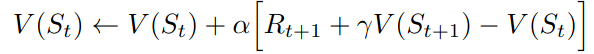

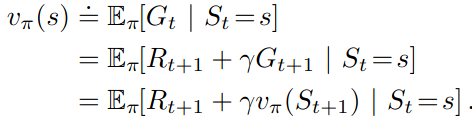

In [18]:
class TD():
    """Collection of Temporal Difference Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: ActionValueFunction,
        env: gym.Env,
        gamma: float = 0.8,
        alpha: float = 0.1,
        epsilon: float = 0.1,
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct

        self.gamma = gamma      # discount factor
        self.alpha = alpha      # learning rate
        self.epsilon = epsilon  # epsilon for epsilon-greedy policy


    def sarsa(self, num_episodes: int):
        """SARSA On-Policy TD Control"""
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            action = self.actor.epsilon_greedy_action(state, self.epsilon)
            terminated = truncated = False

            while not terminated and not truncated:
                state_, reward, terminated, truncated, _ = self.env.step(action)
                # Choose next action using epsilon-greedy
                action_ = self.actor.epsilon_greedy_action(state_, self.epsilon)

                # Update Q-value using SARSA update rule
                q_value = self.value_function.get_value(state, action)
                q_value_ = self.value_function.get_value(state_, action_)

                td_target = reward + self.gamma * q_value_
                td_error = td_target - q_value
                q_val_new = q_value + self.alpha * td_error

                self.value_function.set_value(state, action, q_val_new)

                # Update actor
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(state, action_values, self.epsilon)
                
                state, action = state_, action_


            if episode % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)
            
            print(f'Episode {episode} completed.')

    def q_learning(self, num_episodes: int):
        """Q-Learning Off-Policy TD Control"""
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            terminated = truncated = False

            while not terminated and not truncated:
                action = self.actor.epsilon_greedy_action(state, self.epsilon)
                state_, reward, terminated, truncated, _ = self.env.step(action)

                # Update Q-value using Q-learning update rule
                q_value = self.value_function.get_value(state, action)
                best_action_ = self.actor.greedy_action(state_)
                best_action_value_ = self.value_function.get_value(state_, best_action_)

                # calculate
                td_target = reward + self.gamma * best_action_value_
                td_error = td_target - q_value
                q_value_new = q_value + self.alpha * td_error

                self.value_function.set_value(state, action, q_value_new)

                # Update policy
                action_values = self.value_function.get_action_values_from_state(state)
                self.actor.update_policy_epsilon_greedy(state, action_values, self.epsilon)

                state = state_
            
            if episode % 100 == 0:
                plot_gridworld_action(self.value_function, (self.env.unwrapped.size, self.env.unwrapped.size), self.actor)
        
            print(f'Episode {episode} completed.')


    def train_sarsa(self, num_episodes: int):
        print("[Info] - Starting SARSA Algorithm Training")
        self.sarsa(num_episodes)

        return self.value_function, self.actor

    def train_q_learning(self, num_episodes: int):
        print("[Info] - Starting Q-Learning Algorithm Training")
        self.q_learning(num_episodes)

        return self.value_function, self.actor

# SARSA


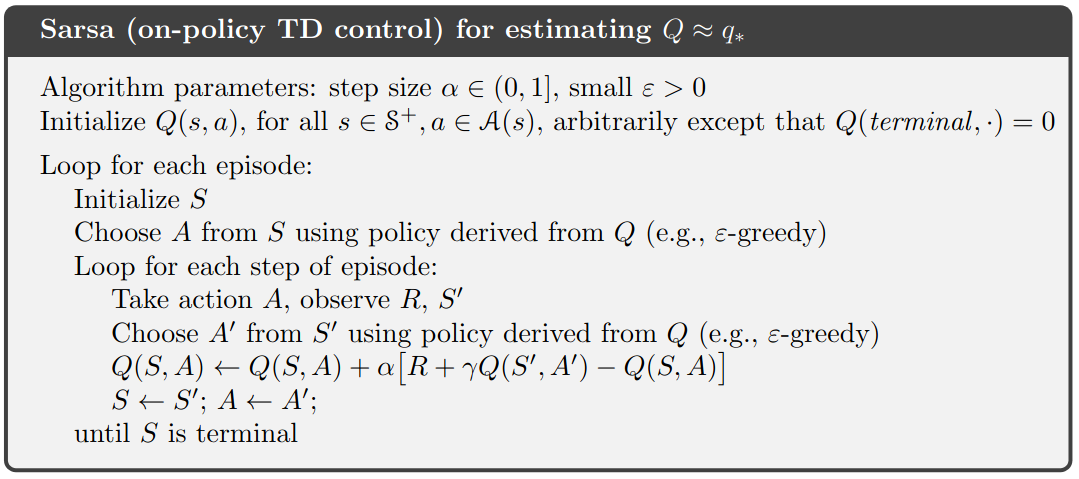

[Info] - Starting SARSA Algorithm Training


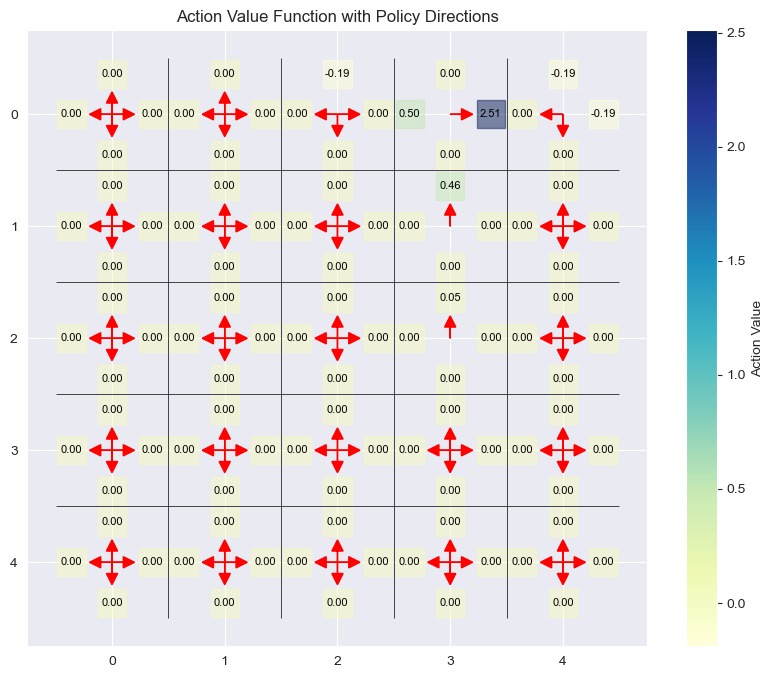

Episode 0 completed.
Episode 1 completed.
Episode 2 completed.
Episode 3 completed.
Episode 4 completed.
Episode 5 completed.
Episode 6 completed.
Episode 7 completed.
Episode 8 completed.
Episode 9 completed.
Episode 10 completed.
Episode 11 completed.
Episode 12 completed.
Episode 13 completed.
Episode 14 completed.
Episode 15 completed.
Episode 16 completed.
Episode 17 completed.
Episode 18 completed.
Episode 19 completed.
Episode 20 completed.
Episode 21 completed.
Episode 22 completed.
Episode 23 completed.
Episode 24 completed.
Episode 25 completed.
Episode 26 completed.
Episode 27 completed.
Episode 28 completed.
Episode 29 completed.
Episode 30 completed.
Episode 31 completed.
Episode 32 completed.
Episode 33 completed.
Episode 34 completed.
Episode 35 completed.
Episode 36 completed.
Episode 37 completed.
Episode 38 completed.
Episode 39 completed.
Episode 40 completed.
Episode 41 completed.
Episode 42 completed.
Episode 43 completed.
Episode 44 completed.
Episode 45 completed

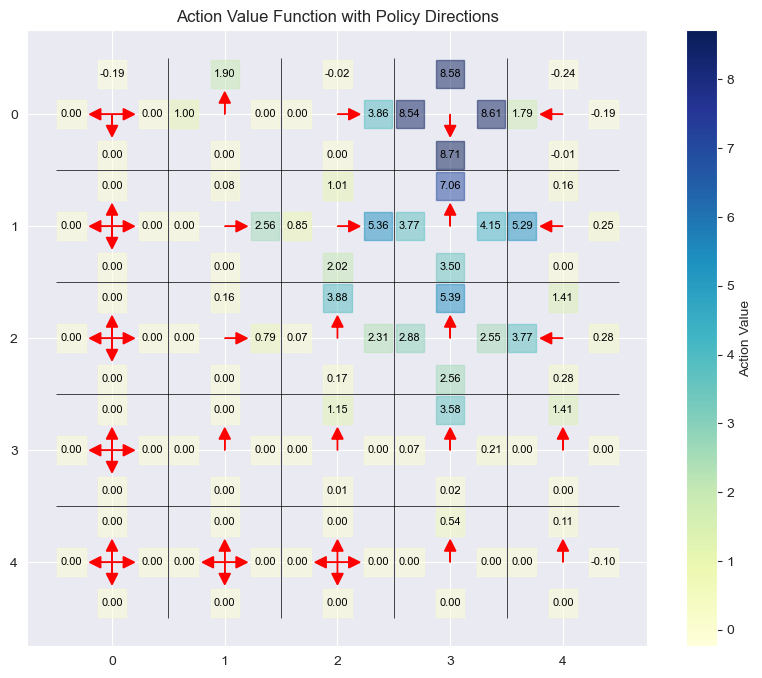

Episode 100 completed.
Episode 101 completed.
Episode 102 completed.
Episode 103 completed.
Episode 104 completed.
Episode 105 completed.
Episode 106 completed.
Episode 107 completed.
Episode 108 completed.
Episode 109 completed.
Episode 110 completed.
Episode 111 completed.
Episode 112 completed.
Episode 113 completed.
Episode 114 completed.
Episode 115 completed.
Episode 116 completed.
Episode 117 completed.
Episode 118 completed.
Episode 119 completed.
Episode 120 completed.
Episode 121 completed.
Episode 122 completed.
Episode 123 completed.
Episode 124 completed.
Episode 125 completed.
Episode 126 completed.
Episode 127 completed.
Episode 128 completed.
Episode 129 completed.
Episode 130 completed.
Episode 131 completed.
Episode 132 completed.
Episode 133 completed.
Episode 134 completed.
Episode 135 completed.
Episode 136 completed.
Episode 137 completed.
Episode 138 completed.
Episode 139 completed.
Episode 140 completed.
Episode 141 completed.
Episode 142 completed.
Episode 143

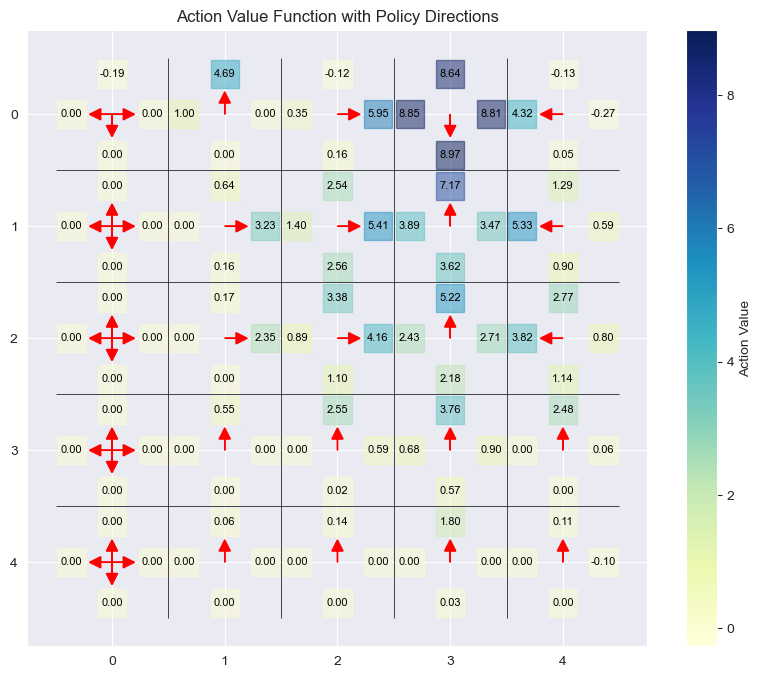

Episode 200 completed.
Episode 201 completed.
Episode 202 completed.
Episode 203 completed.
Episode 204 completed.
Episode 205 completed.
Episode 206 completed.
Episode 207 completed.
Episode 208 completed.
Episode 209 completed.
Episode 210 completed.
Episode 211 completed.
Episode 212 completed.
Episode 213 completed.
Episode 214 completed.
Episode 215 completed.
Episode 216 completed.
Episode 217 completed.
Episode 218 completed.
Episode 219 completed.
Episode 220 completed.
Episode 221 completed.
Episode 222 completed.
Episode 223 completed.
Episode 224 completed.
Episode 225 completed.
Episode 226 completed.
Episode 227 completed.
Episode 228 completed.
Episode 229 completed.
Episode 230 completed.
Episode 231 completed.
Episode 232 completed.
Episode 233 completed.
Episode 234 completed.
Episode 235 completed.
Episode 236 completed.
Episode 237 completed.
Episode 238 completed.
Episode 239 completed.
Episode 240 completed.
Episode 241 completed.
Episode 242 completed.
Episode 243

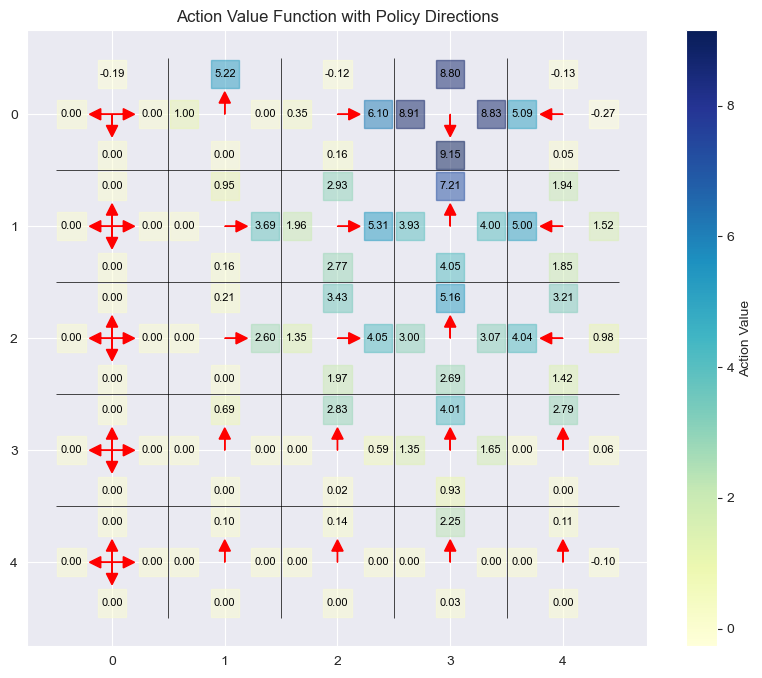

Episode 300 completed.
Episode 301 completed.
Episode 302 completed.
Episode 303 completed.
Episode 304 completed.
Episode 305 completed.
Episode 306 completed.
Episode 307 completed.
Episode 308 completed.
Episode 309 completed.
Episode 310 completed.
Episode 311 completed.
Episode 312 completed.
Episode 313 completed.
Episode 314 completed.
Episode 315 completed.
Episode 316 completed.
Episode 317 completed.
Episode 318 completed.
Episode 319 completed.
Episode 320 completed.
Episode 321 completed.
Episode 322 completed.
Episode 323 completed.
Episode 324 completed.
Episode 325 completed.
Episode 326 completed.
Episode 327 completed.
Episode 328 completed.
Episode 329 completed.
Episode 330 completed.
Episode 331 completed.
Episode 332 completed.
Episode 333 completed.
Episode 334 completed.
Episode 335 completed.
Episode 336 completed.
Episode 337 completed.
Episode 338 completed.
Episode 339 completed.
Episode 340 completed.
Episode 341 completed.
Episode 342 completed.
Episode 343

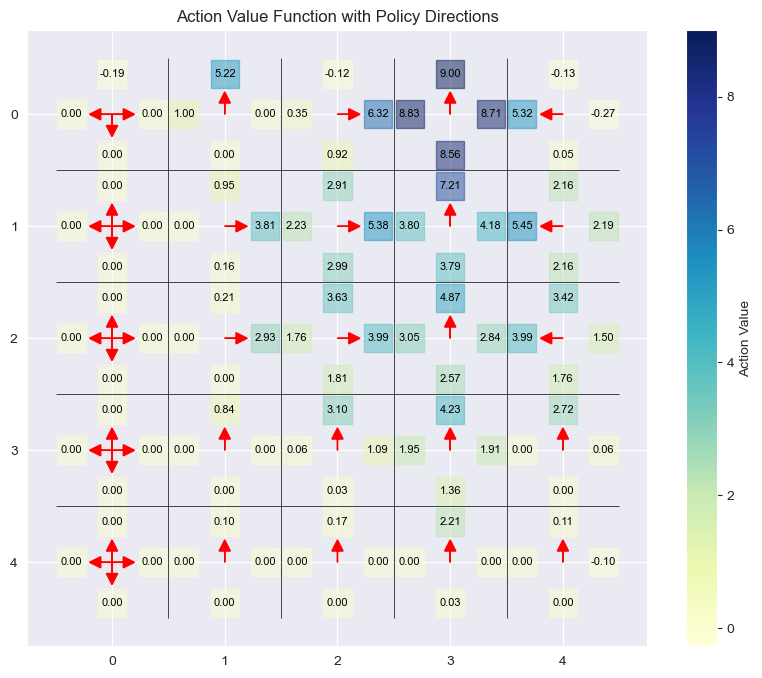

Episode 400 completed.
Episode 401 completed.
Episode 402 completed.
Episode 403 completed.
Episode 404 completed.
Episode 405 completed.
Episode 406 completed.
Episode 407 completed.
Episode 408 completed.
Episode 409 completed.
Episode 410 completed.
Episode 411 completed.
Episode 412 completed.
Episode 413 completed.
Episode 414 completed.
Episode 415 completed.
Episode 416 completed.
Episode 417 completed.
Episode 418 completed.
Episode 419 completed.
Episode 420 completed.
Episode 421 completed.
Episode 422 completed.
Episode 423 completed.
Episode 424 completed.
Episode 425 completed.
Episode 426 completed.
Episode 427 completed.
Episode 428 completed.
Episode 429 completed.
Episode 430 completed.
Episode 431 completed.
Episode 432 completed.
Episode 433 completed.
Episode 434 completed.
Episode 435 completed.
Episode 436 completed.
Episode 437 completed.
Episode 438 completed.
Episode 439 completed.
Episode 440 completed.
Episode 441 completed.
Episode 442 completed.
Episode 443

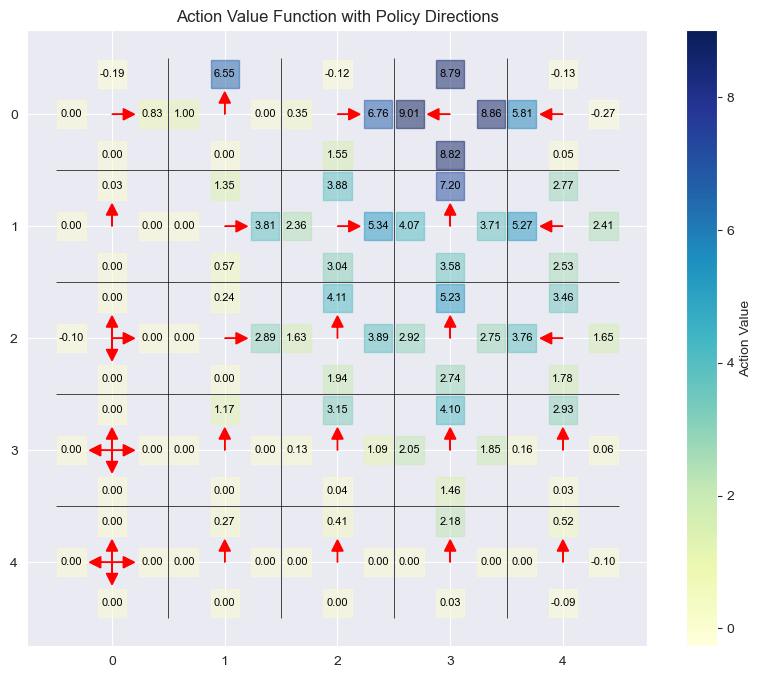

Episode 500 completed.
Episode 501 completed.
Episode 502 completed.
Episode 503 completed.
Episode 504 completed.
Episode 505 completed.
Episode 506 completed.
Episode 507 completed.
Episode 508 completed.
Episode 509 completed.
Episode 510 completed.
Episode 511 completed.
Episode 512 completed.
Episode 513 completed.
Episode 514 completed.
Episode 515 completed.
Episode 516 completed.
Episode 517 completed.
Episode 518 completed.
Episode 519 completed.
Episode 520 completed.
Episode 521 completed.
Episode 522 completed.
Episode 523 completed.
Episode 524 completed.
Episode 525 completed.
Episode 526 completed.
Episode 527 completed.
Episode 528 completed.
Episode 529 completed.
Episode 530 completed.
Episode 531 completed.
Episode 532 completed.
Episode 533 completed.
Episode 534 completed.
Episode 535 completed.
Episode 536 completed.
Episode 537 completed.
Episode 538 completed.
Episode 539 completed.
Episode 540 completed.
Episode 541 completed.
Episode 542 completed.
Episode 543

Episode 600 completed.
Episode 601 completed.
Episode 602 completed.
Episode 603 completed.
Episode 604 completed.
Episode 605 completed.
Episode 606 completed.
Episode 607 completed.
Episode 608 completed.
Episode 609 completed.
Episode 610 completed.
Episode 611 completed.
Episode 612 completed.
Episode 613 completed.
Episode 614 completed.
Episode 615 completed.
Episode 616 completed.
Episode 617 completed.
Episode 618 completed.
Episode 619 completed.
Episode 620 completed.
Episode 621 completed.
Episode 622 completed.
Episode 623 completed.
Episode 624 completed.
Episode 625 completed.
Episode 626 completed.
Episode 627 completed.
Episode 628 completed.
Episode 629 completed.
Episode 630 completed.
Episode 631 completed.
Episode 632 completed.
Episode 633 completed.
Episode 634 completed.
Episode 635 completed.
Episode 636 completed.
Episode 637 completed.
Episode 638 completed.
Episode 639 completed.
Episode 640 completed.
Episode 641 completed.
Episode 642 completed.
Episode 643

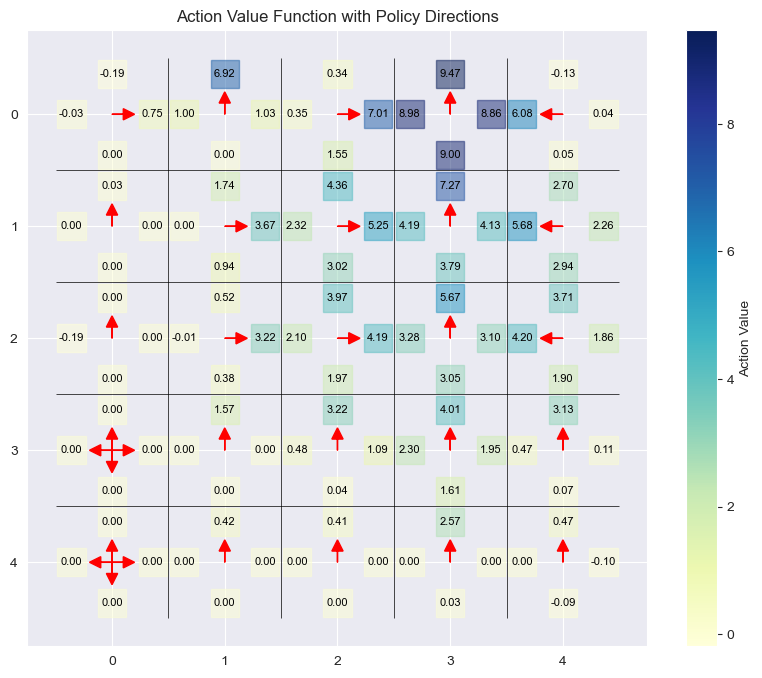

Episode 700 completed.
Episode 701 completed.
Episode 702 completed.
Episode 703 completed.
Episode 704 completed.
Episode 705 completed.
Episode 706 completed.
Episode 707 completed.
Episode 708 completed.
Episode 709 completed.
Episode 710 completed.
Episode 711 completed.
Episode 712 completed.
Episode 713 completed.
Episode 714 completed.
Episode 715 completed.
Episode 716 completed.
Episode 717 completed.
Episode 718 completed.
Episode 719 completed.
Episode 720 completed.
Episode 721 completed.
Episode 722 completed.
Episode 723 completed.
Episode 724 completed.
Episode 725 completed.
Episode 726 completed.
Episode 727 completed.
Episode 728 completed.
Episode 729 completed.
Episode 730 completed.
Episode 731 completed.
Episode 732 completed.
Episode 733 completed.
Episode 734 completed.
Episode 735 completed.
Episode 736 completed.
Episode 737 completed.
Episode 738 completed.
Episode 739 completed.
Episode 740 completed.
Episode 741 completed.
Episode 742 completed.
Episode 743

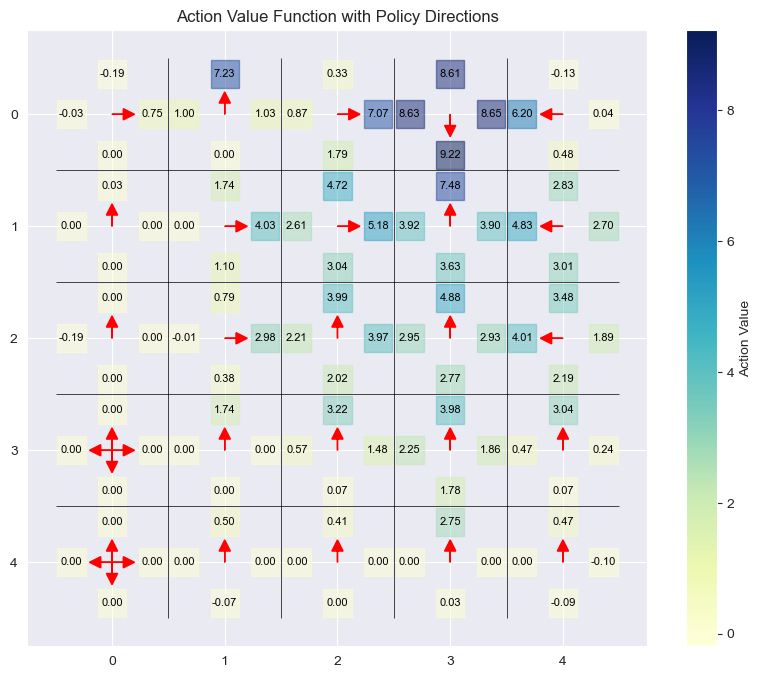

Episode 800 completed.
Episode 801 completed.
Episode 802 completed.
Episode 803 completed.
Episode 804 completed.
Episode 805 completed.
Episode 806 completed.
Episode 807 completed.
Episode 808 completed.
Episode 809 completed.
Episode 810 completed.
Episode 811 completed.
Episode 812 completed.
Episode 813 completed.
Episode 814 completed.
Episode 815 completed.
Episode 816 completed.
Episode 817 completed.
Episode 818 completed.
Episode 819 completed.
Episode 820 completed.
Episode 821 completed.
Episode 822 completed.
Episode 823 completed.
Episode 824 completed.
Episode 825 completed.
Episode 826 completed.
Episode 827 completed.
Episode 828 completed.
Episode 829 completed.
Episode 830 completed.
Episode 831 completed.
Episode 832 completed.
Episode 833 completed.
Episode 834 completed.
Episode 835 completed.
Episode 836 completed.
Episode 837 completed.
Episode 838 completed.
Episode 839 completed.
Episode 840 completed.
Episode 841 completed.
Episode 842 completed.
Episode 843

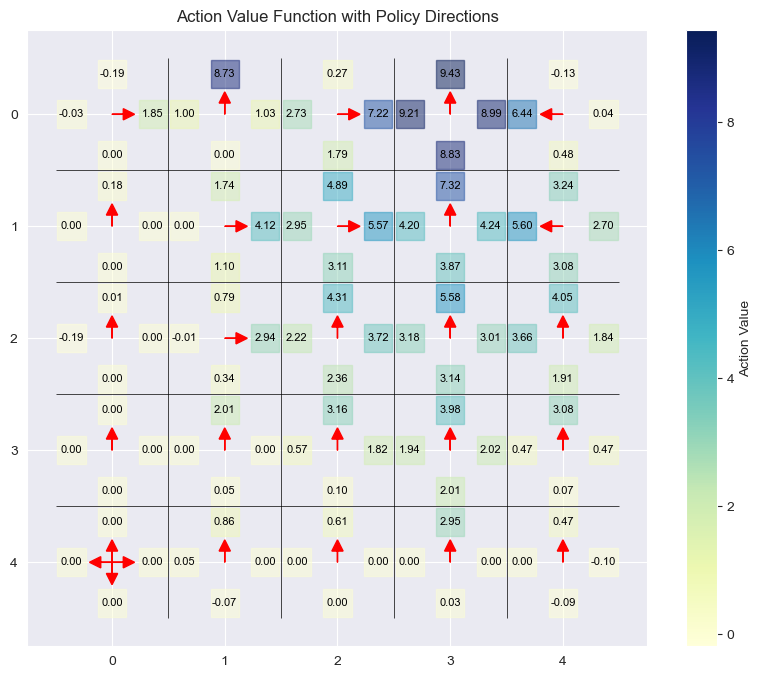

Episode 900 completed.
Episode 901 completed.
Episode 902 completed.
Episode 903 completed.
Episode 904 completed.
Episode 905 completed.
Episode 906 completed.
Episode 907 completed.
Episode 908 completed.
Episode 909 completed.
Episode 910 completed.
Episode 911 completed.
Episode 912 completed.
Episode 913 completed.
Episode 914 completed.
Episode 915 completed.
Episode 916 completed.
Episode 917 completed.
Episode 918 completed.
Episode 919 completed.
Episode 920 completed.
Episode 921 completed.
Episode 922 completed.
Episode 923 completed.
Episode 924 completed.
Episode 925 completed.
Episode 926 completed.
Episode 927 completed.
Episode 928 completed.
Episode 929 completed.
Episode 930 completed.
Episode 931 completed.
Episode 932 completed.
Episode 933 completed.
Episode 934 completed.
Episode 935 completed.
Episode 936 completed.
Episode 937 completed.
Episode 938 completed.
Episode 939 completed.
Episode 940 completed.
Episode 941 completed.
Episode 942 completed.
Episode 943

(<__main__.ActionValueFunction at 0x22070822a30>,
 <__main__.Actor at 0x22070822160>)

In [19]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = TD(actor, value_function, env, gamma=0.8, alpha=0.1, epsilon=0.2)

algorithm.train_sarsa(1_000)

# Q-Learning

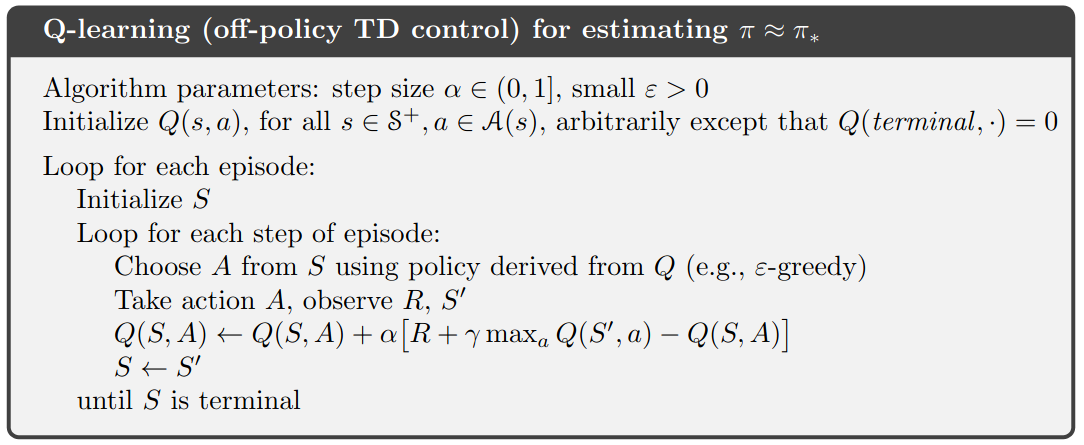

[Info] - Starting Q-Learning Algorithm Training


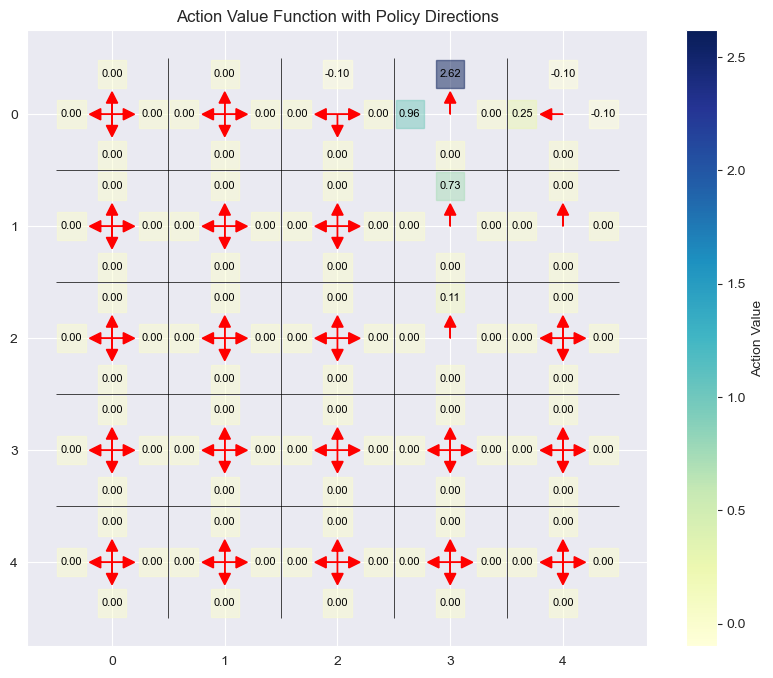

Episode 0 completed.
Episode 1 completed.
Episode 2 completed.
Episode 3 completed.
Episode 4 completed.
Episode 5 completed.
Episode 6 completed.
Episode 7 completed.
Episode 8 completed.
Episode 9 completed.
Episode 10 completed.
Episode 11 completed.
Episode 12 completed.
Episode 13 completed.
Episode 14 completed.
Episode 15 completed.
Episode 16 completed.
Episode 17 completed.
Episode 18 completed.
Episode 19 completed.
Episode 20 completed.
Episode 21 completed.
Episode 22 completed.
Episode 23 completed.
Episode 24 completed.
Episode 25 completed.
Episode 26 completed.
Episode 27 completed.
Episode 28 completed.
Episode 29 completed.
Episode 30 completed.
Episode 31 completed.
Episode 32 completed.
Episode 33 completed.
Episode 34 completed.
Episode 35 completed.
Episode 36 completed.
Episode 37 completed.
Episode 38 completed.
Episode 39 completed.
Episode 40 completed.
Episode 41 completed.
Episode 42 completed.
Episode 43 completed.
Episode 44 completed.
Episode 45 completed

Episode 100 completed.
Episode 101 completed.
Episode 102 completed.
Episode 103 completed.
Episode 104 completed.
Episode 105 completed.
Episode 106 completed.
Episode 107 completed.
Episode 108 completed.
Episode 109 completed.
Episode 110 completed.
Episode 111 completed.
Episode 112 completed.
Episode 113 completed.
Episode 114 completed.
Episode 115 completed.
Episode 116 completed.
Episode 117 completed.
Episode 118 completed.
Episode 119 completed.
Episode 120 completed.
Episode 121 completed.
Episode 122 completed.
Episode 123 completed.
Episode 124 completed.
Episode 125 completed.
Episode 126 completed.
Episode 127 completed.
Episode 128 completed.
Episode 129 completed.
Episode 130 completed.
Episode 131 completed.
Episode 132 completed.
Episode 133 completed.
Episode 134 completed.
Episode 135 completed.
Episode 136 completed.
Episode 137 completed.
Episode 138 completed.
Episode 139 completed.
Episode 140 completed.
Episode 141 completed.
Episode 142 completed.
Episode 143

Episode 200 completed.
Episode 201 completed.
Episode 202 completed.
Episode 203 completed.
Episode 204 completed.
Episode 205 completed.
Episode 206 completed.
Episode 207 completed.
Episode 208 completed.
Episode 209 completed.
Episode 210 completed.
Episode 211 completed.
Episode 212 completed.
Episode 213 completed.
Episode 214 completed.
Episode 215 completed.
Episode 216 completed.
Episode 217 completed.
Episode 218 completed.
Episode 219 completed.
Episode 220 completed.
Episode 221 completed.
Episode 222 completed.
Episode 223 completed.
Episode 224 completed.
Episode 225 completed.
Episode 226 completed.
Episode 227 completed.
Episode 228 completed.
Episode 229 completed.
Episode 230 completed.
Episode 231 completed.
Episode 232 completed.
Episode 233 completed.
Episode 234 completed.
Episode 235 completed.
Episode 236 completed.
Episode 237 completed.
Episode 238 completed.
Episode 239 completed.
Episode 240 completed.
Episode 241 completed.
Episode 242 completed.
Episode 243

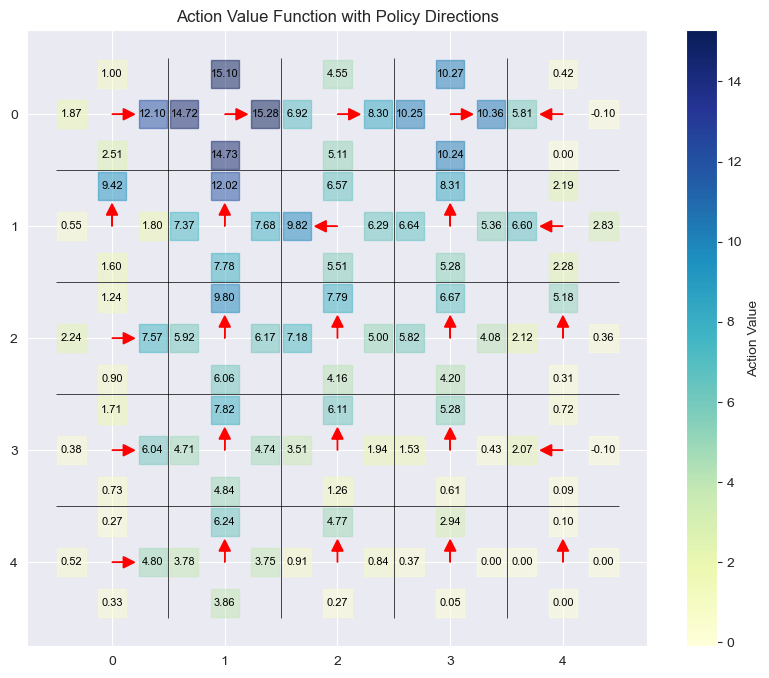

Episode 300 completed.
Episode 301 completed.
Episode 302 completed.
Episode 303 completed.
Episode 304 completed.
Episode 305 completed.
Episode 306 completed.
Episode 307 completed.
Episode 308 completed.
Episode 309 completed.
Episode 310 completed.
Episode 311 completed.
Episode 312 completed.
Episode 313 completed.
Episode 314 completed.
Episode 315 completed.
Episode 316 completed.
Episode 317 completed.
Episode 318 completed.
Episode 319 completed.
Episode 320 completed.
Episode 321 completed.
Episode 322 completed.
Episode 323 completed.
Episode 324 completed.
Episode 325 completed.
Episode 326 completed.
Episode 327 completed.
Episode 328 completed.
Episode 329 completed.
Episode 330 completed.
Episode 331 completed.
Episode 332 completed.
Episode 333 completed.
Episode 334 completed.
Episode 335 completed.
Episode 336 completed.
Episode 337 completed.
Episode 338 completed.
Episode 339 completed.
Episode 340 completed.
Episode 341 completed.
Episode 342 completed.
Episode 343

Episode 400 completed.
Episode 401 completed.
Episode 402 completed.
Episode 403 completed.
Episode 404 completed.
Episode 405 completed.
Episode 406 completed.
Episode 407 completed.
Episode 408 completed.
Episode 409 completed.
Episode 410 completed.
Episode 411 completed.
Episode 412 completed.
Episode 413 completed.
Episode 414 completed.
Episode 415 completed.
Episode 416 completed.
Episode 417 completed.
Episode 418 completed.
Episode 419 completed.
Episode 420 completed.
Episode 421 completed.
Episode 422 completed.
Episode 423 completed.
Episode 424 completed.
Episode 425 completed.
Episode 426 completed.
Episode 427 completed.
Episode 428 completed.
Episode 429 completed.
Episode 430 completed.
Episode 431 completed.
Episode 432 completed.
Episode 433 completed.
Episode 434 completed.
Episode 435 completed.
Episode 436 completed.
Episode 437 completed.
Episode 438 completed.
Episode 439 completed.
Episode 440 completed.
Episode 441 completed.
Episode 442 completed.
Episode 443

Episode 500 completed.
Episode 501 completed.
Episode 502 completed.
Episode 503 completed.
Episode 504 completed.
Episode 505 completed.
Episode 506 completed.
Episode 507 completed.
Episode 508 completed.
Episode 509 completed.
Episode 510 completed.
Episode 511 completed.
Episode 512 completed.
Episode 513 completed.
Episode 514 completed.
Episode 515 completed.
Episode 516 completed.
Episode 517 completed.
Episode 518 completed.
Episode 519 completed.
Episode 520 completed.
Episode 521 completed.
Episode 522 completed.
Episode 523 completed.
Episode 524 completed.
Episode 525 completed.
Episode 526 completed.
Episode 527 completed.
Episode 528 completed.
Episode 529 completed.
Episode 530 completed.
Episode 531 completed.
Episode 532 completed.
Episode 533 completed.
Episode 534 completed.
Episode 535 completed.
Episode 536 completed.
Episode 537 completed.
Episode 538 completed.
Episode 539 completed.
Episode 540 completed.
Episode 541 completed.
Episode 542 completed.
Episode 543

Episode 600 completed.
Episode 601 completed.
Episode 602 completed.
Episode 603 completed.
Episode 604 completed.
Episode 605 completed.
Episode 606 completed.
Episode 607 completed.
Episode 608 completed.
Episode 609 completed.
Episode 610 completed.
Episode 611 completed.
Episode 612 completed.
Episode 613 completed.
Episode 614 completed.
Episode 615 completed.
Episode 616 completed.
Episode 617 completed.
Episode 618 completed.
Episode 619 completed.
Episode 620 completed.
Episode 621 completed.
Episode 622 completed.
Episode 623 completed.
Episode 624 completed.
Episode 625 completed.
Episode 626 completed.
Episode 627 completed.
Episode 628 completed.
Episode 629 completed.
Episode 630 completed.
Episode 631 completed.
Episode 632 completed.
Episode 633 completed.
Episode 634 completed.
Episode 635 completed.
Episode 636 completed.
Episode 637 completed.
Episode 638 completed.
Episode 639 completed.
Episode 640 completed.
Episode 641 completed.
Episode 642 completed.
Episode 643

Episode 700 completed.
Episode 701 completed.
Episode 702 completed.
Episode 703 completed.
Episode 704 completed.
Episode 705 completed.
Episode 706 completed.
Episode 707 completed.
Episode 708 completed.
Episode 709 completed.
Episode 710 completed.
Episode 711 completed.
Episode 712 completed.
Episode 713 completed.
Episode 714 completed.
Episode 715 completed.
Episode 716 completed.
Episode 717 completed.
Episode 718 completed.
Episode 719 completed.
Episode 720 completed.
Episode 721 completed.
Episode 722 completed.
Episode 723 completed.
Episode 724 completed.
Episode 725 completed.
Episode 726 completed.
Episode 727 completed.
Episode 728 completed.
Episode 729 completed.
Episode 730 completed.
Episode 731 completed.
Episode 732 completed.
Episode 733 completed.
Episode 734 completed.
Episode 735 completed.
Episode 736 completed.
Episode 737 completed.
Episode 738 completed.
Episode 739 completed.
Episode 740 completed.
Episode 741 completed.
Episode 742 completed.
Episode 743

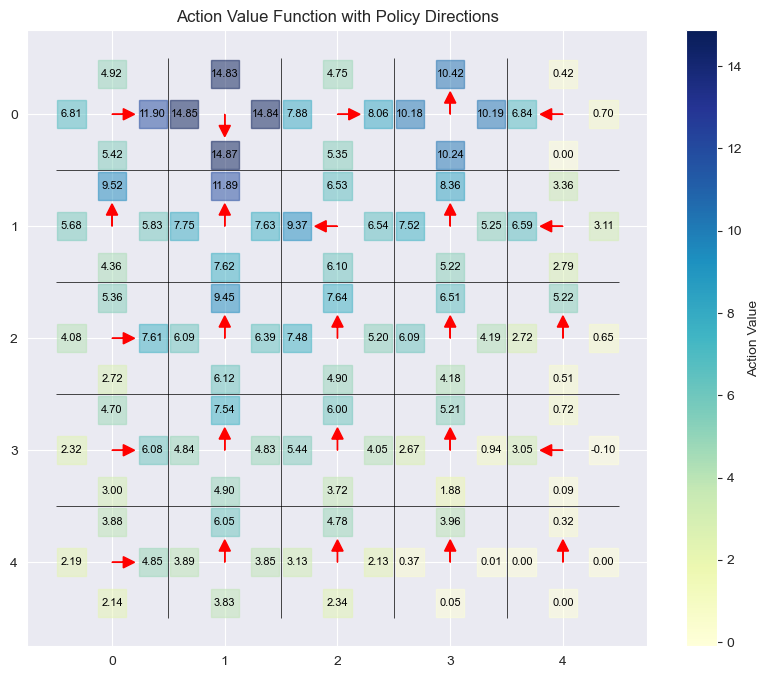

Episode 800 completed.
Episode 801 completed.
Episode 802 completed.
Episode 803 completed.
Episode 804 completed.
Episode 805 completed.
Episode 806 completed.
Episode 807 completed.
Episode 808 completed.
Episode 809 completed.
Episode 810 completed.
Episode 811 completed.
Episode 812 completed.
Episode 813 completed.
Episode 814 completed.
Episode 815 completed.
Episode 816 completed.
Episode 817 completed.
Episode 818 completed.
Episode 819 completed.
Episode 820 completed.
Episode 821 completed.
Episode 822 completed.
Episode 823 completed.
Episode 824 completed.
Episode 825 completed.
Episode 826 completed.
Episode 827 completed.
Episode 828 completed.
Episode 829 completed.
Episode 830 completed.
Episode 831 completed.
Episode 832 completed.
Episode 833 completed.
Episode 834 completed.
Episode 835 completed.
Episode 836 completed.
Episode 837 completed.
Episode 838 completed.
Episode 839 completed.
Episode 840 completed.
Episode 841 completed.
Episode 842 completed.
Episode 843

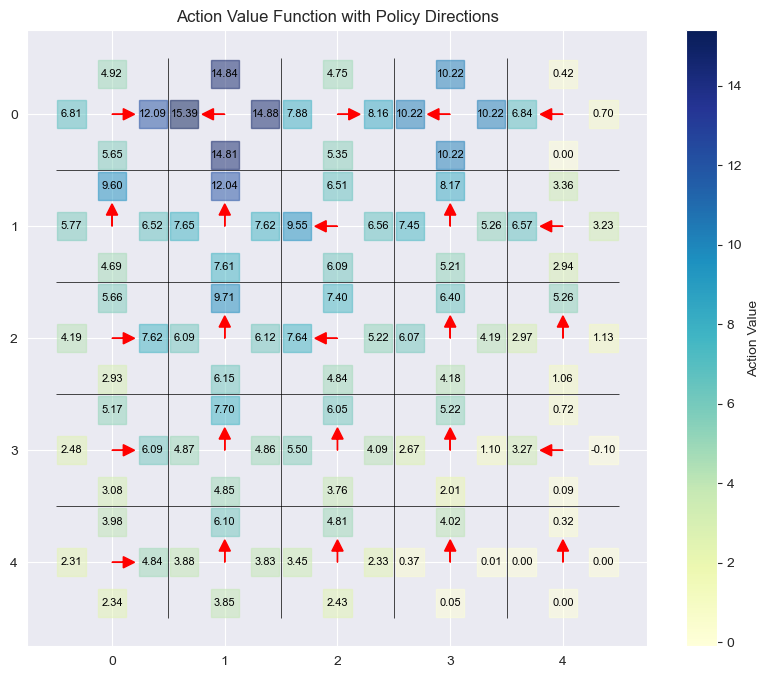

Episode 900 completed.
Episode 901 completed.
Episode 902 completed.
Episode 903 completed.
Episode 904 completed.
Episode 905 completed.
Episode 906 completed.
Episode 907 completed.
Episode 908 completed.
Episode 909 completed.
Episode 910 completed.
Episode 911 completed.
Episode 912 completed.
Episode 913 completed.
Episode 914 completed.
Episode 915 completed.
Episode 916 completed.
Episode 917 completed.
Episode 918 completed.
Episode 919 completed.
Episode 920 completed.
Episode 921 completed.
Episode 922 completed.
Episode 923 completed.
Episode 924 completed.
Episode 925 completed.
Episode 926 completed.
Episode 927 completed.
Episode 928 completed.
Episode 929 completed.
Episode 930 completed.
Episode 931 completed.
Episode 932 completed.
Episode 933 completed.
Episode 934 completed.
Episode 935 completed.
Episode 936 completed.
Episode 937 completed.
Episode 938 completed.
Episode 939 completed.
Episode 940 completed.
Episode 941 completed.
Episode 942 completed.
Episode 943

(<__main__.ActionValueFunction at 0x220708227f0>,
 <__main__.Actor at 0x220708224c0>)

In [20]:
env = GridWorldWrapper(gym.make("gridworld-v0", start_state=np.array([2, 2]), upper_steps=50))
env.reset()

grid_shape = env.observation_space.high + 1

actor = Actor(num_states=grid_shape, num_actions=env.action_space.n)
value_function = ActionValueFunction(state_space_shape=grid_shape, n_actions=env.action_space.n)
algorithm = TD(actor, value_function, env, gamma=0.8, alpha=0.1, epsilon=0.2)

algorithm.train_q_learning(1_000)